In [ ]:
import urllib.request
urllib.request.urlretrieve("https://storage.yandexcloud.net/audioml-contest22/dataset.tar.gz", "dataset.tar.gz")

KeyboardInterrupt: ignored

In [ ]:
#!python naive_baseline.py --features-dir /content/train_features --tracks-meta /content/train_meta.tsv --output /content/out/text.txt

In [ ]:
from google.colab import drive
drive.mount('drive')
#!cp /content/train_meta.tsv "drive/My Drive/"

MessageError: ignored

In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/train_features.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/train_features')

In [ ]:
import shutil
shutil.copy("/content/drive/MyDrive/train_meta.tsv", "/content/")

'/content/train_meta.tsv'

In [ ]:
!cp /content/train_meta.tsv "drive/My Drive/"

In [ ]:
import tarfile
import zipfile
zipfile = '/content/dataset.tar.gz'
if zipfile.endswith("tar.gz"):
    tar = tarfile.open(zipfile, "r:gz")
elif zipfile.endswith("tar"):
    tar = tarfile.open(zipfile, "r:")
tar.extractall()
tar.close()  

In [ ]:
!pip install annoy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 4.7 MB/s 
  Created wheel for annoy: filename=annoy-1.17.1-cp37-cp37m-linux_x86_64.whl size=395193 sha256=03310bb99eebd0238ccda55e2acbf5b895e36c9f3f89b7694755ed8f70ee06f1
  Stored in directory: /root/.cache/pip/wheels/81/94/bf/92cb0e4fef8770fe9c6df0ba588fca30ab7c306b6048ae8a54
Successfully built annoy


In [ ]:
# encoding=utf-8
import numpy as np
import pandas as pd
import os
from argparse import ArgumentParser
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from tqdm import tqdm
import random
import annoy

In [ ]:


# Data Loader 

def train_val_split(dataset, val_size = 0.2): # Сплит по artistid
    artist_ids = dataset['artistid'].unique()
    train_artist_ids, val_artist_ids = train_test_split(artist_ids, test_size = val_size)
    trainset = dataset[dataset['artistid'].isin(train_artist_ids)].copy()
    valset = dataset[dataset['artistid'].isin(val_artist_ids)].copy()
    return trainset, valset

class FeaturesLoader: 
    def __init__(self, features_dir_path, meta_info, device='cpu', crop_size = 60):
        self.features_dir_path = features_dir_path
        self.meta_info = meta_info
        self.trackid2path = meta_info.set_index('trackid')['archive_features_path'].to_dict()
        self.crop_size = crop_size
        self.device = device
        
    def _load_item(self, track_id):
        track_features_file_path = self.trackid2path[track_id]
        track_features = np.load(os.path.join(self.features_dir_path, track_features_file_path))
        padding = (track_features.shape[1] - self.crop_size) // 2
        return track_features[:, padding:padding+self.crop_size]
    
    def load_batch(self, tracks_ids):
        batch = [self._load_item(track_id) for track_id in tracks_ids]
        return torch.tensor(np.array(batch)).to(self.device)

class TrainLoader:
    def __init__(self, features_loader, batch_size = 256, features_size = (512, 60)):
        self.features_loader = features_loader
        self.batch_size = batch_size
        self.features_size = features_size
        self.artist_track_ids = self.features_loader.meta_info.groupby('artistid').agg(list)
        
    def _generate_pairs(self, track_ids):
        np.random.shuffle(track_ids)
        pairs = [track_ids[i-2:i] for i in range(2, len(track_ids)+1, 2)]
        return pairs
        
    def _get_pair_ids(self):
        artist_track_ids = self.artist_track_ids.copy()
        artist_track_pairs = artist_track_ids['trackid'].map(self._generate_pairs)
        for pair_ids in artist_track_pairs.explode().dropna():
            yield pair_ids
            
    def _get_batch(self, batch_ids):
        batch_ids = np.array(batch_ids).reshape(-1)
        batch_features = self.features_loader.load_batch(batch_ids)
        batch_features = batch_features.reshape(self.batch_size, 2, *self.features_size)
        return batch_features
        
    def __iter__(self):
        batch_ids = []
        for pair_ids in self._get_pair_ids():
            batch_ids.append(pair_ids)
            if len(batch_ids) == self.batch_size:
                batch = self._get_batch(batch_ids)
                yield batch
                batch_ids = []

class TestLoader:
    def __init__(self, features_loader, batch_size = 256, features_size = (512, 60)):
        self.features_loader = features_loader
        self.batch_size = batch_size
        self.features_size = features_size
        
    def __iter__(self):
        batch_ids = []
        for track_id in tqdm(self.features_loader.meta_info['trackid'].values):
            batch_ids.append(track_id)
            if len(batch_ids) == self.batch_size:
                yield batch_ids, self.features_loader.load_batch(batch_ids) 
                batch_ids = []
        if len(batch_ids) > 0:
            yield batch_ids, self.features_loader.load_batch(batch_ids) 





In [ ]:
FeaturesLoader.load_batch

In [ ]:
# Loss & Metrics

class NT_Xent(nn.Module):
    def __init__(self, temperature):
        super(NT_Xent, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        N = 2 * batch_size
        z = torch.cat((z_i, z_j), dim=0)
 
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)

        mask = self.mask_correlated_samples(batch_size)
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        with torch.no_grad():
            top1_negative_samples, _ = negative_samples.topk(1)
            avg_rank = logits.argsort(descending=True).argmin(dim=1).float().mean().cpu().numpy()

        return loss, avg_rank

def get_ranked_list(embeds, top_size, annoy_num_trees = 32):
    annoy_index = None
    annoy2id = []
    id2annoy = dict()
    for track_id, track_embed in embeds.items():
        id2annoy[track_id] = len(annoy2id)
        annoy2id.append(track_id)
        if annoy_index is None:
            annoy_index = annoy.AnnoyIndex(len(track_embed), 'angular')
        annoy_index.add_item(id2annoy[track_id], track_embed)
    annoy_index.build(annoy_num_trees)
    ranked_list = dict()
    for track_id in embeds.keys():
        candidates = annoy_index.get_nns_by_item(id2annoy[track_id], top_size+1)[1:] # exclude trackid itself
        candidates = list(filter(lambda x: x != id2annoy[track_id], candidates))
        ranked_list[track_id] = [annoy2id[candidate] for candidate in candidates]
    return ranked_list

def position_discounter(position):
    return 1.0 / np.log2(position+1)   

def get_ideal_dcg(relevant_items_count, top_size):
    dcg = 0.0
    for result_indx in range(min(top_size, relevant_items_count)):
        position = result_indx + 1
        dcg += position_discounter(position)
    return dcg

def compute_dcg(query_trackid, ranked_list, track2artist_map, top_size):
    query_artistid = track2artist_map[query_trackid]
    dcg = 0.0
    for result_indx, result_trackid in enumerate(ranked_list[:top_size]):
        assert result_trackid != query_trackid
        position = result_indx + 1
        discounted_position = position_discounter(position)
        result_artistid = track2artist_map[result_trackid]
        if result_artistid == query_artistid:
            dcg += discounted_position
    return dcg

def eval_submission(submission, gt_meta_info, top_size = 100):
    track2artist_map = gt_meta_info.set_index('trackid')['artistid'].to_dict()
    artist2tracks_map = gt_meta_info.groupby('artistid').agg(list)['trackid'].to_dict()
    ndcg_list = []
    for query_trackid in tqdm(submission.keys()):
        ranked_list = submission[query_trackid]
        query_artistid = track2artist_map[query_trackid]
        query_artist_tracks_count = len(artist2tracks_map[query_artistid])
        ideal_dcg = get_ideal_dcg(query_artist_tracks_count-1, top_size=top_size)
        dcg = compute_dcg(query_trackid, ranked_list, track2artist_map, top_size=top_size)
        try:
            ndcg_list.append(dcg/ideal_dcg)
        except ZeroDivisionError:
            continue
    return np.mean(ndcg_list)


In [ ]:
def train(module, train_loader, val_loader, valset_meta, optimizer, criterion, num_epochs, checkpoint_path, top_size = 100):
    max_ndcg = None
    for epoch in range(num_epochs):
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            module.train()
            x_i, x_j = batch[:, 0, :, :], batch[:, 1, :, :]
            h_i, h_j, z_i, z_j = module(x_i, x_j)
            loss, avg_rank = criterion(z_i, z_j)
            loss.backward()
            optimizer.step()
            print("Epoch {}/{}".format(epoch+1, num_epochs))
            print("loss: {}".format(loss))
            print("avg_rank: {}".format(avg_rank))
            print()
        
        with torch.no_grad():
            model_encoder = module.encoder
            embeds_encoder = inference(model_encoder, val_loader)
            ranked_list_encoder = get_ranked_list(embeds_encoder, top_size)
            val_ndcg_encoder = eval_submission(ranked_list_encoder, valset_meta)
            
            model_projector = nn.Sequential(module.encoder, module.projector)
            embeds_projector = inference1(model_projector, val_loader)
            ranked_list_projector = get_ranked_list(embeds_projector, top_size)
            val_ndcg_projector = eval_submission(ranked_list_projector, valset_meta)
            
            print("Validation nDCG on epoch {}".format(epoch))
            print("Encoder - {}".format(val_ndcg_encoder))
            print("Projector - {}".format(val_ndcg_projector))
            if (max_ndcg is None) or (val_ndcg_encoder > max_ndcg):
                max_ndcg = val_ndcg_encoder
                torch.save(model_encoder.state_dict(), checkpoint_path)

def save_submission(submission, submission_path):
    with open(submission_path, 'w') as f:
        for query_trackid, result in submission.items():
            f.write("{}\t{}\n".format(query_trackid, " ".join(map(str, result))))

In [ ]:
# Train & Inference functions

class BasicNet(nn.Module):
    def __init__(self, output_features_size):
        super().__init__()
        self.output_features_size = output_features_size
        self.conv_1 = nn.Conv1d(512, output_features_size, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv1d(output_features_size, output_features_size, kernel_size=3, padding=1)
        self.mp_1 = nn.MaxPool1d(2, 2)
        self.conv_3 = nn.Conv1d(output_features_size, output_features_size, kernel_size=3, padding=1)
        self.conv_4 = nn.Conv1d(output_features_size, output_features_size, kernel_size=3, padding=1)
        self.mp_2 = nn.MaxPool1d(2, 2)
        self.conv_5 = nn.Conv1d(output_features_size, output_features_size, kernel_size=3, padding=1)
        self.conv_6 = nn.Conv1d(output_features_size, output_features_size, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = self.mp_1(x)
        x = F.relu(self.conv_3(x))
        x = self.conv_4(x).mean(axis = 2)
        return x

class SimCLR(nn.Module):
    def __init__(self, encoder, projection_dim):
        super().__init__()
        self.encoder = encoder
        self.n_features = 64 #encoder.output_features_size 
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(
            nn.Linear(self.n_features*15, self.n_features, bias=False),
            nn.ReLU(),
            nn.Linear(self.n_features, self.projection_dim, bias=False),
        )
        
    def forward(self, x_i, x_j):
        h_i = self.encoder(x_i).view(-1, 64*15)
        h_j = self.encoder(x_j).view(-1, 64*15)
        #print(x_i.shape)

        #print(h_i.shape)
        #print(h_j.shape)
        
        z_i = self.projector(h_i)
        z_j = self.projector(h_j)
        #z_i = self.projector(h_i.view(-1, 64*15))
        #z_j = self.projector(h_j.view(-1, 64*15))
        return h_i, h_j, z_i, z_j
#(32768x15 and 64x64)
def inference(model, loader):
    embeds = dict()
    for tracks_ids, tracks_features in loader:
        with torch.no_grad():
            tracks_embeds = model(tracks_features).view(-1, 64*15)
            for track_id, track_embed in zip(tracks_ids, tracks_embeds):
                embeds[track_id] = track_embed.cpu().numpy()
    return embeds
def inference(model, loader):
    embeds = dict()
    for tracks_ids, tracks_features in loader:
        with torch.no_grad():
            tracks_embeds = model(tracks_features)
            for track_id, track_embed in zip(tracks_ids, tracks_embeds):
                embeds[track_id] = track_embed.cpu().numpy()
    return embeds

In [ ]:

#parser = ArgumentParser(description='Simple naive baseline')
#parser.add_argument('--base-dir', dest='base_dir', action='store', required=True)
#args = parser.parse_args()

base_dir = '/content'
    # Seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

TRAINSET_DIRNAME = 'train_features'
TESTSET_DIRNAME = 'test_features'
TRAINSET_META_FILENAME = 'train_meta.tsv'
TESTSET_META_FILENAME = 'test_meta.tsv'
SUBMISSION_FILENAME = 'submission.txt'
MODEL_FILENAME = 'model.pt'
CHECKPOINT_FILENAME = 'best.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = 512
N_CHANNELS = 256
PROJECTION_DIM = 128
NUM_EPOCHS = 20
LR = 1e-4
TEMPERATURE = 0.1

TRAINSET_PATH = os.path.join(base_dir, TRAINSET_DIRNAME)
TESTSET_PATH = os.path.join(base_dir, TESTSET_DIRNAME)
TRAINSET_META_PATH = os.path.join(base_dir, TRAINSET_META_FILENAME)
TESTSET_META_PATH = os.path.join(base_dir, TESTSET_META_FILENAME)
SUBMISSION_PATH = os.path.join(base_dir, SUBMISSION_FILENAME)
MODEL_PATH = os.path.join(base_dir, MODEL_FILENAME)
CHECKPOINT_PATH = os.path.join(base_dir, CHECKPOINT_FILENAME)
'''
sim_clr = SimCLR(
    encoder = BasicNet(N_CHANNELS),
    projection_dim = PROJECTION_DIM
).to(device)
'''
sim_clr = SimCLR(
    encoder = autoen.encoder,
    projection_dim = PROJECTION_DIM
).to(device)
train_meta_info = pd.read_csv(TRAINSET_META_PATH, sep='\t')
#test_meta_info = pd.read_csv(TESTSET_META_PATH, sep='\t')
train_meta_info, validation_meta_info = train_val_split(train_meta_info, val_size=0.7)

print("Loaded data")
print("Train set size: {}".format(len(train_meta_info)))
print("Validation set size: {}".format(len(validation_meta_info)))
#print("Test set size: {}".format(len(test_meta_info)))
print()

print("Train")
train(
        module = sim_clr,
        train_loader = TrainLoader(FeaturesLoader(TRAINSET_PATH, train_meta_info, device), batch_size = BATCH_SIZE),
        val_loader = TestLoader(FeaturesLoader(TRAINSET_PATH, validation_meta_info, device), batch_size = BATCH_SIZE),
        valset_meta = validation_meta_info,
        optimizer = torch.optim.Adam(sim_clr.parameters(), lr = LR),
        criterion = NT_Xent(temperature = TEMPERATURE),
        num_epochs = NUM_EPOCHS,
        checkpoint_path = CHECKPOINT_PATH
)

print("Submission")
#test_loader = TestLoader(FeaturesLoader(TESTSET_PATH, test_meta_info, device), batch_size = BATCH_SIZE)
#model = sim_clr.encoder
#embeds = inference(model, test_loader)
#submission = get_ranked_list(embeds, 100)
#save_submission(submission, SUBMISSION_PATH)
#torch.save(sim_clr.state_dict(), MODEL_PATH)

Loaded data
Train set size: 14931
Validation set size: 34935

Train


1it [00:02,  2.86s/it]

Epoch 1/20
loss: 5.782120704650879
avg_rank: 137.927734375



2it [00:05,  2.79s/it]

Epoch 1/20
loss: 5.618890762329102
avg_rank: 118.4296875



3it [00:08,  2.74s/it]

Epoch 1/20
loss: 5.740687847137451
avg_rank: 133.13671875



4it [00:10,  2.71s/it]

Epoch 1/20
loss: 6.134812355041504
avg_rank: 181.6142578125



5it [00:13,  2.69s/it]

Epoch 1/20
loss: 5.833146095275879
avg_rank: 144.828125



6it [00:16,  2.69s/it]

Epoch 1/20
loss: 5.819565773010254
avg_rank: 150.6103515625



7it [00:18,  2.69s/it]

Epoch 1/20
loss: 5.913147926330566
avg_rank: 154.2373046875



8it [00:21,  2.71s/it]

Epoch 1/20
loss: 5.865423202514648
avg_rank: 151.951171875



9it [00:24,  2.74s/it]

Epoch 1/20
loss: 5.927371025085449
avg_rank: 157.3251953125



10it [00:27,  2.74s/it]

Epoch 1/20
loss: 5.812445163726807
avg_rank: 147.75390625



11it [00:30,  2.73s/it]

Epoch 1/20
loss: 5.76015567779541
avg_rank: 139.7119140625



12it [00:32,  2.71s/it]

Epoch 1/20
loss: 5.970620155334473
avg_rank: 169.1513671875



13it [00:35,  2.71s/it]

Epoch 1/20
loss: 5.756602764129639
avg_rank: 135.806640625



14it [00:38,  2.73s/it]


Epoch 1/20
loss: 5.952322483062744
avg_rank: 166.5322265625



100%|██████████| 34935/34935 [01:22<00:00, 421.67it/s]


TypeError: ignored

In [ ]:
train_loader = TrainLoader(FeaturesLoader(TRAINSET_PATH, train_meta_info, device), batch_size = BATCH_SIZE)

In [ ]:
val_loader = TestLoader(FeaturesLoader(TRAINSET_PATH, validation_meta_info, device), batch_size = BATCH_SIZE),

In [ ]:
def trai(module, val_loader):
    model_encoder = module.encoder
    embeds_encoder = inference(model_encoder, val_loader)

In [ ]:
def inferen(loader):
    for tracks_ids, tracks_features in loader:
        i =0

**Encoder**

In [ ]:
def train_ae(module, train_loader,optimizer, criterion, num_epochs): #, val_loader, valset_meta, optimizer, criterion, num_epochs, checkpoint_path, top_size = 100):
    max_ndcg = None
    losses = []
    for epoch in range(num_epochs):
        for tracks_ids, tracks_features in train_loader:
            optimizer.zero_grad()
            module.train()
            reconstructed, _ = module(tracks_features)
            loss = criterion(reconstructed, tracks_features)
            loss.backward()
            optimizer.step()
            print("Epoch {}/{}".format(epoch+1, num_epochs))
            print("loss: {}".format(loss))
            print()
            losses.append(loss.item())
        '''with torch.no_grad():
            module.eval()
            for X_batch in val_loader:
                X_batch = X_batch.view(-1, 3, 64, 64).float()
                reconstructed, _ = model(X_batch.to(device))
                loss = loss_fn(reconstructed.view(-1, 3, 64, 64), X_batch.to(device))
                val_losses_per_epoch.append(loss.item())
            
            print("Validation nDCG on epoch {}".format(epoch))
            print("Encoder - {}".format(val_ndcg_encoder))
            print("Projector - {}".format(val_ndcg_projector))
            if (max_ndcg is None) or (val_ndcg_encoder > max_ndcg):
                max_ndcg = val_ndcg_encoder
                torch.save(model_encoder.state_dict(), checkpoint_path)'''
    return losses

In [ ]:

class Autoencoder(nn.Module):
    def __init__(self, output_features_size):
        super().__init__()
        self.n_features = output_features_size

        self.encoder = nn.Sequential(
            nn.Conv1d(512, self.n_features, kernel_size=3, padding=1),
            nn.Conv1d(self.n_features, self.n_features//2, kernel_size=3, padding=1),

            nn.MaxPool1d(2, 2, return_indices=False),

            nn.Conv1d(self.n_features//2, self.n_features//4, kernel_size=3, padding=1),
            nn.Conv1d(self.n_features//4, self.n_features//8, kernel_size=3, padding=1),

            nn.MaxPool1d(2, 2, return_indices=False),

            nn.Conv1d(self.n_features//8, self.n_features//8, kernel_size=3, padding=1),
            nn.Conv1d(self.n_features//8, self.n_features//8, kernel_size=3, padding=1)
        )
       
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(self.n_features//8, self.n_features//8, kernel_size=3, padding=1),
            nn.ConvTranspose1d(self.n_features//8, self.n_features//4,stride =2, kernel_size=3, padding=0),
           #nn.MaxUnpool1d(2),
            nn.ConvTranspose1d(self.n_features//4, self.n_features//2, kernel_size=3, padding=1),
            nn.ConvTranspose1d(self.n_features//2, self.n_features, kernel_size=3, padding=1),
            #nn.MaxUnpool1d(2),
            nn.ConvTranspose1d(self.n_features, self.n_features,stride = 2,kernel_size=2, padding=1),
            nn.ConvTranspose1d(self.n_features, self.n_features, kernel_size=3, padding=1)
        )

    def forward(self, x):
        print('x.shape ' , x.shape)
        latent = self.encoder(x) #.view(-1, 512)
        print('latent.shape ' ,latent.shape)
        #latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        print('reconstructed.shape ' ,reconstructed.shape)
        return reconstructed, latent


In [ ]:
autoen = Autoencoder(
    output_features_size = 512,
).to(device)

In [ ]:
losses = train_ae(module= autoen,
         train_loader = TestLoader(FeaturesLoader(TRAINSET_PATH, validation_meta_info, device), batch_size = BATCH_SIZE),
         optimizer = torch.optim.Adam(autoen.parameters(), lr = LR),
         criterion = F.mse_loss,
         num_epochs = NUM_EPOCHS)

  1%|▏         | 512/34935 [00:00<00:29, 1176.05it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.28791582584381104



  3%|▎         | 1024/34935 [00:01<00:42, 800.29it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.2851850688457489



  4%|▍         | 1536/34935 [00:02<00:56, 595.25it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.28223875164985657



  6%|▌         | 2048/34935 [00:03<01:00, 547.96it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.28246989846229553



  7%|▋         | 2560/34935 [00:04<01:03, 511.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.2771851420402527



  9%|▉         | 3072/34935 [00:05<01:04, 491.17it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.2747081518173218



 10%|█         | 3584/34935 [00:06<01:06, 471.48it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.2681698501110077



 12%|█▏        | 4096/34935 [00:08<01:07, 454.77it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.2653732895851135



 13%|█▎        | 4608/34935 [00:09<01:07, 446.21it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.25854218006134033



 15%|█▍        | 5120/34935 [00:10<01:07, 441.80it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.25334346294403076



 16%|█▌        | 5632/34935 [00:11<01:06, 442.00it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.24474354088306427



 18%|█▊        | 6144/34935 [00:12<01:05, 442.51it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.22598473727703094



 19%|█▉        | 6656/34935 [00:13<01:03, 443.32it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.20417548716068268



 21%|██        | 7168/34935 [00:15<01:04, 432.97it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.1809355467557907



 22%|██▏       | 7680/34935 [00:16<01:04, 425.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.15582247078418732



 23%|██▎       | 8192/34935 [00:17<01:02, 427.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.14948762953281403



 25%|██▍       | 8704/34935 [00:18<01:01, 429.19it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.17439350485801697



 26%|██▋       | 9216/34935 [00:19<00:59, 431.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.16136577725410461



 28%|██▊       | 9728/34935 [00:21<00:58, 431.18it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.14179721474647522



 29%|██▉       | 10240/34935 [00:22<00:56, 439.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.1380143165588379



 31%|███       | 10752/34935 [00:23<00:55, 437.43it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.1380903273820877



 32%|███▏      | 11264/34935 [00:24<00:54, 432.95it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.1420515775680542



 34%|███▎      | 11776/34935 [00:25<00:54, 427.87it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.1446579396724701



 35%|███▌      | 12288/34935 [00:27<00:52, 429.37it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.14209626615047455



 37%|███▋      | 12800/34935 [00:28<00:50, 438.53it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.14106805622577667



 38%|███▊      | 13312/34935 [00:29<00:50, 431.38it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.13733822107315063



 40%|███▉      | 13824/34935 [00:30<00:49, 426.14it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.13264118134975433



 41%|████      | 14336/34935 [00:31<00:49, 419.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.13033607602119446



 43%|████▎     | 14848/34935 [00:33<00:47, 421.35it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.13384458422660828



 44%|████▍     | 15360/34935 [00:34<00:46, 419.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.13609425723552704



 45%|████▌     | 15872/34935 [00:35<00:45, 418.11it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.13750898838043213



 47%|████▋     | 16384/34935 [00:36<00:44, 415.57it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.13317546248435974



 48%|████▊     | 16896/34935 [00:38<00:44, 407.73it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.13125842809677124



 50%|████▉     | 17408/34935 [00:39<00:42, 408.39it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.129884272813797



 51%|█████▏    | 17920/34935 [00:40<00:41, 405.35it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.1310899704694748



 53%|█████▎    | 18432/34935 [00:41<00:40, 403.00it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.13426955044269562



 54%|█████▍    | 18944/34935 [00:43<00:39, 399.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.13055625557899475



 56%|█████▌    | 19456/34935 [00:44<00:38, 402.89it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.13449430465698242



 57%|█████▋    | 19968/34935 [00:45<00:37, 398.51it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.13278239965438843



 59%|█████▊    | 20480/34935 [00:47<00:36, 397.92it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.13121618330478668



 60%|██████    | 20992/34935 [00:48<00:34, 401.06it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.12883667647838593



 62%|██████▏   | 21504/34935 [00:49<00:33, 401.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.13087624311447144



 63%|██████▎   | 22016/34935 [00:50<00:32, 396.84it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.1291513890028



 64%|██████▍   | 22528/34935 [00:52<00:31, 388.80it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.12960785627365112



 66%|██████▌   | 23040/34935 [00:53<00:31, 376.22it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.13023070991039276



 67%|██████▋   | 23552/34935 [00:54<00:29, 388.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.13046139478683472



 69%|██████▉   | 24064/34935 [00:56<00:27, 392.54it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.12973903119564056



 70%|███████   | 24576/34935 [00:57<00:25, 401.45it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.1287425458431244



 72%|███████▏  | 25088/34935 [00:58<00:24, 405.85it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.12808838486671448



 73%|███████▎  | 25600/34935 [00:59<00:22, 407.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.12904374301433563



 75%|███████▍  | 26112/34935 [01:01<00:22, 394.47it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.1296982765197754



 76%|███████▌  | 26624/34935 [01:02<00:21, 387.69it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.1296185702085495



 78%|███████▊  | 27136/34935 [01:04<00:20, 380.34it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.13042767345905304



 79%|███████▉  | 27648/34935 [01:05<00:19, 377.36it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.12957607209682465



 81%|████████  | 28160/34935 [01:06<00:18, 372.26it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.12780606746673584



 82%|████████▏ | 28672/34935 [01:08<00:16, 374.96it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.12693285942077637



 84%|████████▎ | 29184/34935 [01:09<00:15, 371.81it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.12893089652061462



 85%|████████▌ | 29696/34935 [01:11<00:14, 372.11it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.12835828959941864



 86%|████████▋ | 30208/34935 [01:12<00:12, 365.24it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.1273084431886673



 88%|████████▊ | 30720/34935 [01:13<00:11, 364.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.12795905768871307



 89%|████████▉ | 31232/34935 [01:15<00:10, 369.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.128307044506073



 91%|█████████ | 31744/34935 [01:16<00:08, 366.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.1297992765903473



 92%|█████████▏| 32256/34935 [01:18<00:07, 369.23it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.12823481857776642



 94%|█████████▍| 32768/34935 [01:19<00:05, 374.32it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.12714628875255585



 95%|█████████▌| 33280/34935 [01:20<00:04, 380.65it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.1299382895231247



 97%|█████████▋| 33792/34935 [01:21<00:02, 382.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.13081951439380646



 98%|█████████▊| 34304/34935 [01:23<00:01, 385.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.1300451010465622



100%|██████████| 34935/34935 [01:24<00:00, 412.94it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.12920373678207397



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 1/20
loss: 0.1259935200214386



  1%|▏         | 512/34935 [00:01<01:26, 396.11it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1275862455368042



  3%|▎         | 1024/34935 [00:02<01:16, 443.81it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12890996038913727



  4%|▍         | 1536/34935 [00:03<01:20, 417.07it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12625257670879364



  6%|▌         | 2048/34935 [00:04<01:21, 404.66it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12835104763507843



  7%|▋         | 2560/34935 [00:06<01:21, 398.03it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1284753978252411



  9%|▉         | 3072/34935 [00:07<01:20, 395.91it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12905767560005188



 10%|█         | 3584/34935 [00:08<01:19, 392.82it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12714630365371704



 12%|█▏        | 4096/34935 [00:10<01:16, 403.09it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1279195100069046



 13%|█▎        | 4608/34935 [00:11<01:14, 406.99it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1267942190170288



 15%|█▍        | 5120/34935 [00:12<01:12, 409.07it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12901021540164948



 16%|█▌        | 5632/34935 [00:13<01:10, 413.76it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12820570170879364



 18%|█▊        | 6144/34935 [00:15<01:09, 415.79it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12703609466552734



 19%|█▉        | 6656/34935 [00:16<01:07, 419.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1245063915848732



 21%|██        | 7168/34935 [00:17<01:06, 420.11it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12598657608032227



 22%|██▏       | 7680/34935 [00:18<01:05, 415.76it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12829744815826416



 23%|██▎       | 8192/34935 [00:19<01:04, 416.99it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12611787021160126



 25%|██▍       | 8704/34935 [00:21<01:02, 418.28it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12648892402648926



 26%|██▋       | 9216/34935 [00:22<01:01, 420.95it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12801234424114227



 28%|██▊       | 9728/34935 [00:23<00:58, 427.95it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12718228995800018



 29%|██▉       | 10240/34935 [00:24<00:57, 430.57it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12906897068023682



 31%|███       | 10752/34935 [00:25<00:55, 431.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12657058238983154



 32%|███▏      | 11264/34935 [00:26<00:53, 440.05it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12636369466781616



 34%|███▎      | 11776/34935 [00:28<00:52, 437.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1266445815563202



 35%|███▌      | 12288/34935 [00:29<00:50, 445.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12511156499385834



 37%|███▋      | 12800/34935 [00:30<00:49, 449.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12663982808589935



 38%|███▊      | 13312/34935 [00:31<00:48, 445.88it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12690086662769318



 40%|███▉      | 13824/34935 [00:32<00:47, 441.89it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12637513875961304



 41%|████      | 14336/34935 [00:33<00:46, 444.66it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12592826783657074



 43%|████▎     | 14848/34935 [00:34<00:44, 446.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12763696908950806



 44%|████▍     | 15360/34935 [00:36<00:45, 434.24it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12638376653194427



 45%|████▌     | 15872/34935 [00:37<00:43, 439.19it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1267537623643875



 47%|████▋     | 16384/34935 [00:38<00:41, 444.77it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12472623586654663



 48%|████▊     | 16896/34935 [00:39<00:41, 437.81it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12585517764091492



 50%|████▉     | 17408/34935 [00:40<00:40, 437.19it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1255730241537094



 51%|█████▏    | 17920/34935 [00:42<00:39, 433.96it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12615010142326355



 53%|█████▎    | 18432/34935 [00:43<00:38, 431.31it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12811505794525146



 54%|█████▍    | 18944/34935 [00:44<00:37, 424.84it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12375207245349884



 56%|█████▌    | 19456/34935 [00:45<00:36, 425.13it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12762033939361572



 57%|█████▋    | 19968/34935 [00:46<00:35, 422.51it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.126695916056633



 59%|█████▊    | 20480/34935 [00:48<00:34, 421.54it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12643963098526



 60%|██████    | 20992/34935 [00:49<00:32, 425.09it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1251007318496704



 62%|██████▏   | 21504/34935 [00:50<00:32, 417.66it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12730517983436584



 63%|██████▎   | 22016/34935 [00:51<00:31, 408.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1250024139881134



 64%|██████▍   | 22528/34935 [00:53<00:30, 406.92it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12480179965496063



 66%|██████▌   | 23040/34935 [00:54<00:29, 400.36it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1253935992717743



 67%|██████▋   | 23552/34935 [00:55<00:28, 400.01it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12623164057731628



 69%|██████▉   | 24064/34935 [00:57<00:27, 397.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1262172907590866



 70%|███████   | 24576/34935 [00:58<00:26, 394.79it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12549862265586853



 72%|███████▏  | 25088/34935 [00:59<00:24, 396.28it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12456276267766953



 73%|███████▎  | 25600/34935 [01:01<00:23, 395.23it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12517860531806946



 75%|███████▍  | 26112/34935 [01:02<00:22, 397.46it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12570026516914368



 76%|███████▌  | 26624/34935 [01:03<00:20, 400.35it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12576135993003845



 78%|███████▊  | 27136/34935 [01:04<00:19, 397.89it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12688766419887543



 79%|███████▉  | 27648/34935 [01:06<00:18, 402.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12629425525665283



 81%|████████  | 28160/34935 [01:07<00:17, 397.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1246161013841629



 82%|████████▏ | 28672/34935 [01:08<00:15, 399.11it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12372146546840668



 84%|████████▎ | 29184/34935 [01:09<00:14, 398.27it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1255292147397995



 85%|████████▌ | 29696/34935 [01:11<00:13, 393.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12484896183013916



 86%|████████▋ | 30208/34935 [01:12<00:12, 392.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12394370138645172



 88%|████████▊ | 30720/34935 [01:13<00:10, 391.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12481848895549774



 89%|████████▉ | 31232/34935 [01:15<00:09, 383.01it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1252710521221161



 91%|█████████ | 31744/34935 [01:16<00:08, 371.13it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12676842510700226



 92%|█████████▏| 32256/34935 [01:18<00:07, 360.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12513120472431183



 94%|█████████▍| 32768/34935 [01:19<00:06, 360.13it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12407481670379639



 95%|█████████▌| 33280/34935 [01:21<00:04, 359.39it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12684662640094757



 97%|█████████▋| 33792/34935 [01:22<00:03, 358.39it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1277766078710556



 98%|█████████▊| 34304/34935 [01:24<00:01, 362.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12713317573070526



100%|██████████| 34935/34935 [01:25<00:00, 408.89it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.12629064917564392



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 2/20
loss: 0.12321382015943527



  1%|▏         | 512/34935 [00:01<01:36, 357.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12471617758274078



  3%|▎         | 1024/34935 [00:02<01:36, 350.45it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12610416114330292



  4%|▍         | 1536/34935 [00:04<01:34, 353.39it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12347260117530823



  6%|▌         | 2048/34935 [00:05<01:36, 342.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12556041777133942



  7%|▋         | 2560/34935 [00:07<01:34, 343.19it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.1257520169019699



  9%|▉         | 3072/34935 [00:08<01:31, 346.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12634995579719543



 10%|█         | 3584/34935 [00:10<01:29, 351.61it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12444544583559036



 12%|█▏        | 4096/34935 [00:11<01:27, 353.98it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.125258669257164



 13%|█▎        | 4608/34935 [00:13<01:25, 354.25it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12418313324451447



 15%|█▍        | 5120/34935 [00:14<01:24, 352.59it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.126424178481102



 16%|█▌        | 5632/34935 [00:15<01:22, 356.48it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12560588121414185



 18%|█▊        | 6144/34935 [00:17<01:20, 359.61it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12452369928359985



 19%|█▉        | 6656/34935 [00:18<01:18, 361.53it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12196433544158936



 21%|██        | 7168/34935 [00:20<01:16, 364.52it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12343744188547134



 22%|██▏       | 7680/34935 [00:21<01:14, 364.77it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12585100531578064



 23%|██▎       | 8192/34935 [00:22<01:13, 363.21it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12359774112701416



 25%|██▍       | 8704/34935 [00:24<01:11, 365.26it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12406475841999054



 26%|██▋       | 9216/34935 [00:25<01:09, 371.07it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12560752034187317



 28%|██▊       | 9728/34935 [00:26<01:06, 378.49it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12482675909996033



 29%|██▉       | 10240/34935 [00:28<01:04, 380.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12672506272792816



 31%|███       | 10752/34935 [00:29<01:03, 378.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.1242324709892273



 32%|███▏      | 11264/34935 [00:31<01:02, 378.11it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12405896186828613



 34%|███▎      | 11776/34935 [00:32<01:00, 382.79it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12431448698043823



 35%|███▌      | 12288/34935 [00:33<00:58, 386.32it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12287158519029617



 37%|███▋      | 12800/34935 [00:34<00:56, 388.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12440801411867142



 38%|███▊      | 13312/34935 [00:36<00:55, 390.17it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.1246890127658844



 40%|███▉      | 13824/34935 [00:37<00:54, 387.05it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12421334534883499



 41%|████      | 14336/34935 [00:38<00:52, 394.81it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12387814372777939



 43%|████▎     | 14848/34935 [00:40<00:50, 396.23it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.1255435049533844



 44%|████▍     | 15360/34935 [00:41<00:49, 394.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.1243462935090065



 45%|████▌     | 15872/34935 [00:42<00:48, 395.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12473659962415695



 47%|████▋     | 16384/34935 [00:44<00:47, 392.78it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12273097783327103



 48%|████▊     | 16896/34935 [00:45<00:45, 394.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.1239561140537262



 50%|████▉     | 17408/34935 [00:46<00:44, 396.49it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12363554537296295



 51%|█████▏    | 17920/34935 [00:48<00:44, 380.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12428820133209229



 53%|█████▎    | 18432/34935 [00:49<00:42, 386.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12624654173851013



 54%|█████▍    | 18944/34935 [00:50<00:41, 387.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.1219651848077774



 56%|█████▌    | 19456/34935 [00:51<00:39, 391.38it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.1258821338415146



 57%|█████▋    | 19968/34935 [00:53<00:38, 393.09it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12491204589605331



 59%|█████▊    | 20480/34935 [00:54<00:36, 390.82it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12474358081817627



 60%|██████    | 20992/34935 [00:55<00:35, 396.63it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12345146387815475



 62%|██████▏   | 21504/34935 [00:57<00:33, 398.21it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12571190297603607



 63%|██████▎   | 22016/34935 [00:58<00:33, 391.31it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.123345285654068



 64%|██████▍   | 22528/34935 [00:59<00:31, 396.01it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12324217706918716



 66%|██████▌   | 23040/34935 [01:01<00:30, 389.59it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.1238560751080513



 67%|██████▋   | 23552/34935 [01:02<00:29, 392.48it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12479080259799957



 69%|██████▉   | 24064/34935 [01:03<00:27, 388.53it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12478217482566833



 70%|███████   | 24576/34935 [01:04<00:26, 393.43it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12414278090000153



 72%|███████▏  | 25088/34935 [01:06<00:24, 397.12it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12319228798151016



 73%|███████▎  | 25600/34935 [01:07<00:23, 394.97it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.1238529235124588



 75%|███████▍  | 26112/34935 [01:08<00:22, 395.27it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12440003454685211



 76%|███████▌  | 26624/34935 [01:10<00:21, 394.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12450740486383438



 78%|███████▊  | 27136/34935 [01:11<00:19, 394.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12558868527412415



 79%|███████▉  | 27648/34935 [01:12<00:18, 398.18it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12504160404205322



 81%|████████  | 28160/34935 [01:13<00:17, 394.88it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12338671088218689



 82%|████████▏ | 28672/34935 [01:15<00:15, 398.80it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12258414179086685



 84%|████████▎ | 29184/34935 [01:16<00:14, 396.38it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12435107678174973



 85%|████████▌ | 29696/34935 [01:17<00:13, 394.37it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12367058545351028



 86%|████████▋ | 30208/34935 [01:19<00:11, 397.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12277483940124512



 88%|████████▊ | 30720/34935 [01:20<00:10, 401.91it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12362754344940186



 89%|████████▉ | 31232/34935 [01:21<00:09, 394.65it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12410824000835419



 91%|█████████ | 31744/34935 [01:23<00:08, 386.53it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12561871111392975



 92%|█████████▏| 32256/34935 [01:24<00:06, 382.94it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.1240287721157074



 94%|█████████▍| 32768/34935 [01:25<00:05, 384.59it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12295784056186676



 95%|█████████▌| 33280/34935 [01:27<00:04, 384.86it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12578177452087402



 97%|█████████▋| 33792/34935 [01:28<00:02, 383.12it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12662634253501892



 98%|█████████▊| 34304/34935 [01:29<00:01, 388.13it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.1260189712047577



100%|██████████| 34935/34935 [01:31<00:00, 383.37it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12520019710063934



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 3/20
loss: 0.12197323143482208



  1%|▏         | 512/34935 [00:01<01:33, 366.43it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12363587319850922



  3%|▎         | 1024/34935 [00:02<01:33, 361.08it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12510740756988525



  4%|▍         | 1536/34935 [00:04<01:33, 358.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1223374605178833



  6%|▌         | 2048/34935 [00:05<01:32, 354.85it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12452340126037598



  7%|▋         | 2560/34935 [00:07<01:29, 361.78it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12482649087905884



  9%|▉         | 3072/34935 [00:08<01:27, 362.47it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1253243237733841



 10%|█         | 3584/34935 [00:09<01:25, 368.65it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1234935075044632



 12%|█▏        | 4096/34935 [00:11<01:24, 364.97it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12423843145370483



 13%|█▎        | 4608/34935 [00:12<01:25, 356.31it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12324649840593338



 15%|█▍        | 5120/34935 [00:14<01:24, 353.86it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1254812479019165



 16%|█▌        | 5632/34935 [00:15<01:22, 355.49it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12465726584196091



 18%|█▊        | 6144/34935 [00:17<01:19, 359.96it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12350547313690186



 19%|█▉        | 6656/34935 [00:18<01:18, 361.70it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12100349366664886



 21%|██        | 7168/34935 [00:19<01:16, 363.30it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12249083071947098



 22%|██▏       | 7680/34935 [00:21<01:15, 363.13it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12488056719303131



 23%|██▎       | 8192/34935 [00:22<01:14, 359.24it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12263855338096619



 25%|██▍       | 8704/34935 [00:24<01:12, 360.57it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1231333464384079



 26%|██▋       | 9216/34935 [00:25<01:11, 360.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12467405945062637



 28%|██▊       | 9728/34935 [00:26<01:09, 364.31it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12390291690826416



 29%|██▉       | 10240/34935 [00:28<01:06, 369.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1258576214313507



 31%|███       | 10752/34935 [00:29<01:04, 374.32it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12334715574979782



 32%|███▏      | 11264/34935 [00:30<01:02, 377.84it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12318342924118042



 34%|███▎      | 11776/34935 [00:32<01:00, 383.51it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1234087198972702



 35%|███▌      | 12288/34935 [00:33<00:59, 380.57it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12194731831550598



 37%|███▋      | 12800/34935 [00:34<00:57, 383.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12347570061683655



 38%|███▊      | 13312/34935 [00:36<00:56, 382.80it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12381858378648758



 40%|███▉      | 13824/34935 [00:37<00:55, 377.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1232704371213913



 41%|████      | 14336/34935 [00:38<00:54, 380.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12291167676448822



 43%|████▎     | 14848/34935 [00:40<00:52, 384.78it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12461339682340622



 44%|████▍     | 15360/34935 [00:41<00:51, 379.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.123360276222229



 45%|████▌     | 15872/34935 [00:43<00:50, 377.34it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12383474409580231



 47%|████▋     | 16384/34935 [00:44<00:49, 377.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12180763483047485



 48%|████▊     | 16896/34935 [00:45<00:47, 378.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12302777916193008



 50%|████▉     | 17408/34935 [00:47<00:46, 378.49it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1227092295885086



 51%|█████▏    | 17920/34935 [00:48<00:45, 377.25it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12339197099208832



 53%|█████▎    | 18432/34935 [00:49<00:43, 382.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1253231316804886



 54%|█████▍    | 18944/34935 [00:51<00:42, 378.19it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12108361721038818



 56%|█████▌    | 19456/34935 [00:52<00:40, 380.25it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12493299692869186



 57%|█████▋    | 19968/34935 [00:53<00:39, 378.86it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.123966284096241



 59%|█████▊    | 20480/34935 [00:55<00:38, 378.36it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12381748110055923



 60%|██████    | 20992/34935 [00:56<00:36, 377.26it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12249886989593506



 62%|██████▏   | 21504/34935 [00:57<00:35, 378.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12472207099199295



 63%|██████▎   | 22016/34935 [00:59<00:33, 380.01it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12227272242307663



 64%|██████▍   | 22528/34935 [01:00<00:32, 384.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12219893932342529



 66%|██████▌   | 23040/34935 [01:01<00:30, 384.50it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12278024852275848



 67%|██████▋   | 23552/34935 [01:03<00:29, 379.73it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1238776296377182



 69%|██████▉   | 24064/34935 [01:04<00:29, 374.48it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12372063845396042



 70%|███████   | 24576/34935 [01:05<00:27, 379.01it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12312130630016327



 72%|███████▏  | 25088/34935 [01:07<00:25, 380.21it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12215328216552734



 73%|███████▎  | 25600/34935 [01:08<00:24, 374.25it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12286160886287689



 75%|███████▍  | 26112/34935 [01:10<00:23, 374.96it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12332296371459961



 76%|███████▌  | 26624/34935 [01:11<00:22, 364.35it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1234007403254509



 78%|███████▊  | 27136/34935 [01:12<00:21, 368.91it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12439882755279541



 79%|███████▉  | 27648/34935 [01:14<00:19, 371.32it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12387324869632721



 81%|████████  | 28160/34935 [01:15<00:18, 366.05it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12224754691123962



 82%|████████▏ | 28672/34935 [01:17<00:16, 369.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1213870421051979



 84%|████████▎ | 29184/34935 [01:18<00:15, 367.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12305149435997009



 85%|████████▌ | 29696/34935 [01:19<00:14, 370.26it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12239117175340652



 86%|████████▋ | 30208/34935 [01:21<00:12, 375.95it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12151752412319183



 88%|████████▊ | 30720/34935 [01:22<00:10, 383.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12224960327148438



 89%|████████▉ | 31232/34935 [01:23<00:09, 382.08it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12268493324518204



 91%|█████████ | 31744/34935 [01:25<00:08, 375.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12415744364261627



 92%|█████████▏| 32256/34935 [01:26<00:07, 375.70it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12251488864421844



 94%|█████████▍| 32768/34935 [01:27<00:05, 373.80it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12145589292049408



 95%|█████████▌| 33280/34935 [01:29<00:04, 369.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1243286058306694



 97%|█████████▋| 33792/34935 [01:30<00:03, 360.79it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12490898370742798



 98%|█████████▊| 34304/34935 [01:32<00:01, 365.64it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12433023005723953



100%|██████████| 34935/34935 [01:33<00:00, 373.24it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12348365038633347



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 4/20
loss: 0.11963863670825958



  1%|▏         | 512/34935 [00:01<01:39, 347.04it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.12179634720087051



  3%|▎         | 1024/34935 [00:02<01:37, 347.64it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.12325095385313034



  4%|▍         | 1536/34935 [00:04<01:35, 348.35it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.12031184136867523



  6%|▌         | 2048/34935 [00:05<01:34, 346.53it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.12248233705759048



  7%|▋         | 2560/34935 [00:07<01:34, 344.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.1227235272526741



  9%|▉         | 3072/34935 [00:08<01:31, 346.89it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.1230941042304039



 10%|█         | 3584/34935 [00:10<01:30, 347.99it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.12094781547784805



 12%|█▏        | 4096/34935 [00:11<01:29, 343.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.12156762182712555



 13%|█▎        | 4608/34935 [00:13<01:27, 344.66it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.12056221067905426



 15%|█▍        | 5120/34935 [00:14<01:26, 344.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.12273824959993362



 16%|█▌        | 5632/34935 [00:16<01:24, 347.78it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.1219436377286911



 18%|█▊        | 6144/34935 [00:17<01:21, 353.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.1201958879828453



 19%|█▉        | 6656/34935 [00:19<01:18, 359.11it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11793064326047897



 21%|██        | 7168/34935 [00:20<01:16, 364.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.1194792166352272



 22%|██▏       | 7680/34935 [00:21<01:15, 362.01it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.12130450457334518



 23%|██▎       | 8192/34935 [00:23<01:14, 358.95it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.1191634088754654



 25%|██▍       | 8704/34935 [00:24<01:12, 360.69it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11926059424877167



 26%|██▋       | 9216/34935 [00:26<01:10, 363.01it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.1208256259560585



 28%|██▊       | 9728/34935 [00:27<01:08, 368.79it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.12002871185541153



 29%|██▉       | 10240/34935 [00:28<01:06, 371.88it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.12179284542798996



 31%|███       | 10752/34935 [00:30<01:04, 373.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11943118274211884



 32%|███▏      | 11264/34935 [00:31<01:02, 376.69it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11921431869268417



 34%|███▎      | 11776/34935 [00:32<01:01, 375.49it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.1191738024353981



 35%|███▌      | 12288/34935 [00:34<00:59, 380.22it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11750467866659164



 37%|███▋      | 12800/34935 [00:35<00:57, 382.50it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11922213435173035



 38%|███▊      | 13312/34935 [00:36<00:56, 380.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11951844394207001



 40%|███▉      | 13824/34935 [00:38<00:55, 380.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11861725151538849



 41%|████      | 14336/34935 [00:39<00:53, 386.50it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.118045873939991



 43%|████▎     | 14848/34935 [00:40<00:51, 388.65it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11990097910165787



 44%|████▍     | 15360/34935 [00:42<00:50, 387.39it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11841326206922531



 45%|████▌     | 15872/34935 [00:43<00:49, 386.49it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.1191970705986023



 47%|████▋     | 16384/34935 [00:44<00:47, 386.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11691512912511826



 48%|████▊     | 16896/34935 [00:46<00:46, 383.92it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11841332912445068



 50%|████▉     | 17408/34935 [00:47<00:45, 385.23it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11806804686784744



 51%|█████▏    | 17920/34935 [00:48<00:43, 387.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11897265911102295



 53%|█████▎    | 18432/34935 [00:49<00:42, 390.91it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.12054512649774551



 54%|█████▍    | 18944/34935 [00:51<00:41, 386.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11636959761381149



 56%|█████▌    | 19456/34935 [00:52<00:39, 390.78it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.12005183100700378



 57%|█████▋    | 19968/34935 [00:53<00:38, 389.66it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11915687471628189



 59%|█████▊    | 20480/34935 [00:55<00:37, 388.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11930225789546967



 60%|██████    | 20992/34935 [00:56<00:35, 388.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11742498725652695



 62%|██████▏   | 21504/34935 [00:57<00:34, 388.79it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11967499554157257



 63%|██████▎   | 22016/34935 [00:59<00:33, 390.30it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.1170196682214737



 64%|██████▍   | 22528/34935 [01:00<00:31, 393.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.1173275038599968



 66%|██████▌   | 23040/34935 [01:01<00:30, 395.93it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11793636530637741



 67%|██████▋   | 23552/34935 [01:03<00:28, 395.65it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11899161338806152



 69%|██████▉   | 24064/34935 [01:04<00:28, 387.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11882226914167404



 70%|███████   | 24576/34935 [01:05<00:26, 390.77it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.1184268593788147



 72%|███████▏  | 25088/34935 [01:06<00:25, 393.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11731337755918503



 73%|███████▎  | 25600/34935 [01:08<00:23, 392.22it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.1182786375284195



 75%|███████▍  | 26112/34935 [01:09<00:22, 397.37it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.1185263842344284



 76%|███████▌  | 26624/34935 [01:10<00:20, 397.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11854159832000732



 78%|███████▊  | 27136/34935 [01:12<00:19, 396.40it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11949983239173889



 79%|███████▉  | 27648/34935 [01:13<00:18, 399.94it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11906078457832336



 81%|████████  | 28160/34935 [01:14<00:16, 399.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11783348023891449



 82%|████████▏ | 28672/34935 [01:15<00:15, 400.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11654822528362274



 84%|████████▎ | 29184/34935 [01:17<00:14, 393.50it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11805262416601181



 85%|████████▌ | 29696/34935 [01:18<00:13, 394.48it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11772190034389496



 86%|████████▋ | 30208/34935 [01:19<00:12, 392.23it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11708252131938934



 88%|████████▊ | 30720/34935 [01:21<00:10, 388.76it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11769860237836838



 89%|████████▉ | 31232/34935 [01:22<00:09, 385.87it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.1180470660328865



 91%|█████████ | 31744/34935 [01:23<00:08, 383.68it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11953020840883255



 92%|█████████▏| 32256/34935 [01:25<00:07, 379.38it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11788034439086914



 94%|█████████▍| 32768/34935 [01:26<00:05, 381.66it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.1169760599732399



 95%|█████████▌| 33280/34935 [01:28<00:04, 381.34it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.12003745138645172



 97%|█████████▋| 33792/34935 [01:29<00:03, 375.86it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.12029799818992615



 98%|█████████▊| 34304/34935 [01:30<00:01, 377.31it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.11985132098197937



100%|██████████| 34935/34935 [01:32<00:00, 379.38it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.119122713804245



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 5/20
loss: 0.11523420363664627



  1%|▏         | 512/34935 [00:01<01:33, 369.77it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11758159101009369



  3%|▎         | 1024/34935 [00:02<01:33, 364.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11931527405977249



  4%|▍         | 1536/34935 [00:04<01:32, 360.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11622224748134613



  6%|▌         | 2048/34935 [00:05<01:32, 356.98it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11840298026800156



  7%|▋         | 2560/34935 [00:07<01:28, 364.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11879413574934006



  9%|▉         | 3072/34935 [00:08<01:28, 361.82it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11934655159711838



 10%|█         | 3584/34935 [00:09<01:25, 366.38it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.1170806810259819



 12%|█▏        | 4096/34935 [00:11<01:25, 362.46it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.1177268847823143



 13%|█▎        | 4608/34935 [00:12<01:24, 360.85it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11700022220611572



 15%|█▍        | 5120/34935 [00:14<01:22, 363.05it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11931335926055908



 16%|█▌        | 5632/34935 [00:15<01:18, 373.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11866813153028488



 18%|█▊        | 6144/34935 [00:16<01:15, 378.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.116949662566185



 19%|█▉        | 6656/34935 [00:18<01:15, 376.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11496757715940475



 21%|██        | 7168/34935 [00:19<01:13, 376.99it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11668506264686584



 22%|██▏       | 7680/34935 [00:20<01:12, 376.65it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11857777088880539



 23%|██▎       | 8192/34935 [00:22<01:11, 373.69it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.1165575236082077



 25%|██▍       | 8704/34935 [00:23<01:09, 377.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11679983884096146



 26%|██▋       | 9216/34935 [00:24<01:08, 374.54it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11845726519823074



 28%|██▊       | 9728/34935 [00:26<01:06, 376.63it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11788207292556763



 29%|██▉       | 10240/34935 [00:27<01:05, 376.51it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11970352381467819



 31%|███       | 10752/34935 [00:29<01:04, 374.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11754115670919418



 32%|███▏      | 11264/34935 [00:30<01:02, 375.86it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11749333143234253



 34%|███▎      | 11776/34935 [00:31<01:01, 377.89it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11738944798707962



 35%|███▌      | 12288/34935 [00:33<01:00, 376.28it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11590098589658737



 37%|███▋      | 12800/34935 [00:34<00:58, 376.93it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11764472723007202



 38%|███▊      | 13312/34935 [00:35<00:58, 372.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11782614886760712



 40%|███▉      | 13824/34935 [00:37<00:57, 368.40it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11705110222101212



 41%|████      | 14336/34935 [00:38<00:55, 372.95it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11661913245916367



 43%|████▎     | 14848/34935 [00:39<00:53, 372.99it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11841480433940887



 44%|████▍     | 15360/34935 [00:41<00:52, 375.17it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11699459701776505



 45%|████▌     | 15872/34935 [00:42<00:50, 374.00it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11782734841108322



 47%|████▋     | 16384/34935 [00:44<00:49, 372.69it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11558906733989716



 48%|████▊     | 16896/34935 [00:45<00:48, 370.81it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11717727035284042



 50%|████▉     | 17408/34935 [00:46<00:47, 366.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.1168452799320221



 51%|█████▏    | 17920/34935 [00:48<00:46, 367.62it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11790498346090317



 53%|█████▎    | 18432/34935 [00:49<00:44, 369.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11938755214214325



 54%|█████▍    | 18944/34935 [00:50<00:42, 374.01it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.1151464655995369



 56%|█████▌    | 19456/34935 [00:52<00:40, 380.12it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11886417865753174



 57%|█████▋    | 19968/34935 [00:53<00:39, 377.61it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11797468364238739



 59%|█████▊    | 20480/34935 [00:54<00:38, 379.28it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11810338497161865



 60%|██████    | 20992/34935 [00:56<00:36, 379.70it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11630838364362717



 62%|██████▏   | 21504/34935 [00:57<00:35, 378.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11848806589841843



 63%|██████▎   | 22016/34935 [00:59<00:34, 377.91it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11591541767120361



 64%|██████▍   | 22528/34935 [01:00<00:32, 382.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11634211242198944



 66%|██████▌   | 23040/34935 [01:01<00:31, 379.17it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11688817292451859



 67%|██████▋   | 23552/34935 [01:03<00:29, 380.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11799491196870804



 69%|██████▉   | 24064/34935 [01:04<00:28, 378.37it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11785665154457092



 70%|███████   | 24576/34935 [01:05<00:27, 382.53it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11746196448802948



 72%|███████▏  | 25088/34935 [01:07<00:25, 384.70it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11639339476823807



 73%|███████▎  | 25600/34935 [01:08<00:24, 384.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11724761128425598



 75%|███████▍  | 26112/34935 [01:09<00:23, 382.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11758115142583847



 76%|███████▌  | 26624/34935 [01:11<00:21, 379.43it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11752136051654816



 78%|███████▊  | 27136/34935 [01:12<00:20, 381.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11848416179418564



 79%|███████▉  | 27648/34935 [01:13<00:18, 384.31it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11810843646526337



 81%|████████  | 28160/34935 [01:15<00:17, 383.37it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11691876500844955



 82%|████████▏ | 28672/34935 [01:16<00:16, 385.09it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11564332991838455



 84%|████████▎ | 29184/34935 [01:17<00:14, 384.27it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11711008846759796



 85%|████████▌ | 29696/34935 [01:19<00:13, 382.79it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11682026088237762



 86%|████████▋ | 30208/34935 [01:20<00:12, 383.51it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11618393659591675



 88%|████████▊ | 30720/34935 [01:21<00:11, 382.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11685025691986084



 89%|████████▉ | 31232/34935 [01:23<00:09, 381.69it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11720801144838333



 91%|█████████ | 31744/34935 [01:24<00:08, 378.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11863017082214355



 92%|█████████▏| 32256/34935 [01:25<00:07, 375.63it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11703382432460785



 94%|█████████▍| 32768/34935 [01:27<00:05, 376.45it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11612023413181305



 95%|█████████▌| 33280/34935 [01:28<00:04, 377.19it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11917583644390106



 97%|█████████▋| 33792/34935 [01:29<00:03, 376.17it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11941054463386536



 98%|█████████▊| 34304/34935 [01:31<00:01, 376.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.1190238669514656



100%|██████████| 34935/34935 [01:32<00:00, 376.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 6/20
loss: 0.11822046339511871



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 6/20
loss: 0.11449427902698517



  1%|▏         | 512/34935 [00:01<01:32, 372.84it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11675853282213211



  3%|▎         | 1024/34935 [00:02<01:31, 371.66it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11844086647033691



  4%|▍         | 1536/34935 [00:04<01:30, 370.91it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11533475667238235



  6%|▌         | 2048/34935 [00:05<01:29, 367.92it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.1175418272614479



  7%|▋         | 2560/34935 [00:06<01:26, 372.89it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11796678602695465



  9%|▉         | 3072/34935 [00:08<01:26, 369.19it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11850202083587646



 10%|█         | 3584/34935 [00:09<01:23, 373.32it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11624931544065475



 12%|█▏        | 4096/34935 [00:11<01:22, 372.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11685510724782944



 13%|█▎        | 4608/34935 [00:12<01:21, 372.48it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11613329499959946



 15%|█▍        | 5120/34935 [00:13<01:20, 369.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.1184670478105545



 16%|█▌        | 5632/34935 [00:15<01:18, 374.12it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11780380457639694



 18%|█▊        | 6144/34935 [00:16<01:15, 379.22it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11606599390506744



 19%|█▉        | 6656/34935 [00:17<01:14, 379.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11413431912660599



 21%|██        | 7168/34935 [00:19<01:13, 379.79it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11586696654558182



 22%|██▏       | 7680/34935 [00:20<01:12, 377.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11773035675287247



 23%|██▎       | 8192/34935 [00:21<01:11, 373.36it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11567502468824387



 25%|██▍       | 8704/34935 [00:23<01:09, 375.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11593615263700485



 26%|██▋       | 9216/34935 [00:24<01:07, 378.36it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11756306886672974



 28%|██▊       | 9728/34935 [00:25<01:06, 381.35it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11698067933320999



 29%|██▉       | 10240/34935 [00:27<01:05, 379.35it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11876577883958817



 31%|███       | 10752/34935 [00:28<01:03, 379.68it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11661873757839203



 32%|███▏      | 11264/34935 [00:29<01:01, 382.38it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11660629510879517



 34%|███▎      | 11776/34935 [00:31<01:00, 382.23it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11642933636903763



 35%|███▌      | 12288/34935 [00:32<00:59, 380.69it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11504942178726196



 37%|███▋      | 12800/34935 [00:33<00:58, 381.38it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11673972755670547



 38%|███▊      | 13312/34935 [00:35<00:56, 380.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11692427843809128



 40%|███▉      | 13824/34935 [00:36<00:56, 376.20it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11621661484241486



 41%|████      | 14336/34935 [00:38<00:54, 377.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11579960584640503



 43%|████▎     | 14848/34935 [00:39<00:53, 377.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11751331388950348



 44%|████▍     | 15360/34935 [00:40<00:51, 376.47it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11609406769275665



 45%|████▌     | 15872/34935 [00:42<00:50, 374.32it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11689671128988266



 47%|████▋     | 16384/34935 [00:43<00:50, 369.79it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.1146208867430687



 48%|████▊     | 16896/34935 [00:45<00:48, 368.43it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11625349521636963



 50%|████▉     | 17408/34935 [00:46<00:47, 368.39it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11592771857976913



 51%|█████▏    | 17920/34935 [00:47<00:45, 371.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11702652275562286



 53%|█████▎    | 18432/34935 [00:49<00:44, 369.57it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11847467720508575



 54%|█████▍    | 18944/34935 [00:50<00:42, 373.29it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11418941617012024



 56%|█████▌    | 19456/34935 [00:51<00:41, 374.13it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11794520169496536



 57%|█████▋    | 19968/34935 [00:53<00:40, 373.92it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11704760044813156



 59%|█████▊    | 20480/34935 [00:54<00:38, 374.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11713280528783798



 60%|██████    | 20992/34935 [00:55<00:37, 373.42it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11536262184381485



 62%|██████▏   | 21504/34935 [00:57<00:36, 372.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11752738058567047



 63%|██████▎   | 22016/34935 [00:58<00:34, 370.21it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11493752151727676



 64%|██████▍   | 22528/34935 [01:00<00:32, 377.59it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11542665213346481



 66%|██████▌   | 23040/34935 [01:01<00:31, 377.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11591172963380814



 67%|██████▋   | 23552/34935 [01:02<00:30, 379.06it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11710609495639801



 69%|██████▉   | 24064/34935 [01:04<00:28, 376.79it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11694182455539703



 70%|███████   | 24576/34935 [01:05<00:26, 383.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11644857376813889



 72%|███████▏  | 25088/34935 [01:06<00:25, 386.36it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.1154036894440651



 73%|███████▎  | 25600/34935 [01:08<00:24, 384.11it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11623619496822357



 75%|███████▍  | 26112/34935 [01:09<00:22, 384.87it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11663883924484253



 76%|███████▌  | 26624/34935 [01:10<00:21, 383.77it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11649401485919952



 78%|███████▊  | 27136/34935 [01:12<00:20, 383.49it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11746465414762497



 79%|███████▉  | 27648/34935 [01:13<00:18, 387.37it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11705702543258667



 81%|████████  | 28160/34935 [01:14<00:17, 381.48it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11584857851266861



 82%|████████▏ | 28672/34935 [01:16<00:16, 382.91it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.114640012383461



 84%|████████▎ | 29184/34935 [01:17<00:15, 379.92it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11601606011390686



 85%|████████▌ | 29696/34935 [01:18<00:13, 382.52it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11577136069536209



 86%|████████▋ | 30208/34935 [01:20<00:12, 376.65it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11514465510845184



 88%|████████▊ | 30720/34935 [01:21<00:11, 377.45it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11580388247966766



 89%|████████▉ | 31232/34935 [01:22<00:09, 380.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11607383191585541



 91%|█████████ | 31744/34935 [01:24<00:08, 383.61it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11752498894929886



 92%|█████████▏| 32256/34935 [01:25<00:06, 383.78it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11595592647790909



 94%|█████████▍| 32768/34935 [01:26<00:05, 387.19it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11502282321453094



 95%|█████████▌| 33280/34935 [01:28<00:04, 387.07it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11796826124191284



 97%|█████████▋| 33792/34935 [01:29<00:02, 387.25it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11821308732032776



 98%|█████████▊| 34304/34935 [01:30<00:01, 384.29it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.1178310438990593



100%|██████████| 34935/34935 [01:32<00:00, 379.30it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 7/20
loss: 0.11706320196390152



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 7/20
loss: 0.11351775377988815



  1%|▏         | 512/34935 [00:01<01:33, 369.01it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.1155843511223793



  3%|▎         | 1024/34935 [00:02<01:33, 360.95it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11730512231588364



  4%|▍         | 1536/34935 [00:04<01:32, 360.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11411208659410477



  6%|▌         | 2048/34935 [00:05<01:31, 361.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11634822189807892



  7%|▋         | 2560/34935 [00:07<01:28, 365.39it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11675693839788437



  9%|▉         | 3072/34935 [00:08<01:27, 365.51it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11719512939453125



 10%|█         | 3584/34935 [00:09<01:25, 368.13it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11508505791425705



 12%|█▏        | 4096/34935 [00:11<01:24, 366.38it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11570616811513901



 13%|█▎        | 4608/34935 [00:12<01:23, 365.09it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11502598971128464



 15%|█▍        | 5120/34935 [00:14<01:23, 357.22it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11739658564329147



 16%|█▌        | 5632/34935 [00:15<01:19, 367.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11672084778547287



 18%|█▊        | 6144/34935 [00:16<01:16, 374.42it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11506474763154984



 19%|█▉        | 6656/34935 [00:18<01:15, 375.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11311608552932739



 21%|██        | 7168/34935 [00:19<01:13, 375.98it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11468151956796646



 22%|██▏       | 7680/34935 [00:20<01:12, 373.97it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11647220700979233



 23%|██▎       | 8192/34935 [00:22<01:11, 371.93it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11447018384933472



 25%|██▍       | 8704/34935 [00:23<01:09, 376.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11470693349838257



 26%|██▋       | 9216/34935 [00:24<01:07, 379.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.1162654384970665



 28%|██▊       | 9728/34935 [00:26<01:06, 381.07it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11556123197078705



 29%|██▉       | 10240/34935 [00:27<01:05, 379.42it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11733505874872208



 31%|███       | 10752/34935 [00:28<01:04, 376.88it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.115296371281147



 32%|███▏      | 11264/34935 [00:30<01:03, 371.25it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11526039987802505



 34%|███▎      | 11776/34935 [00:31<01:02, 368.57it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11488175392150879



 35%|███▌      | 12288/34935 [00:33<01:01, 367.20it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11371789872646332



 37%|███▋      | 12800/34935 [00:34<00:59, 369.87it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.1153106614947319



 38%|███▊      | 13312/34935 [00:36<00:59, 360.47it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11549106240272522



 40%|███▉      | 13824/34935 [00:37<00:58, 361.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11476857215166092



 41%|████      | 14336/34935 [00:38<00:56, 367.07it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11446524411439896



 43%|████▎     | 14848/34935 [00:40<00:54, 370.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11609482020139694



 44%|████▍     | 15360/34935 [00:41<00:52, 374.27it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11469059437513351



 45%|████▌     | 15872/34935 [00:42<00:50, 377.46it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11531944572925568



 47%|████▋     | 16384/34935 [00:44<00:49, 373.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11308706551790237



 48%|████▊     | 16896/34935 [00:45<00:48, 375.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11477510631084442



 50%|████▉     | 17408/34935 [00:46<00:46, 380.45it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11432764679193497



 51%|█████▏    | 17920/34935 [00:48<00:44, 380.62it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11551608145236969



 53%|█████▎    | 18432/34935 [00:49<00:42, 384.59it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11694206297397614



 54%|█████▍    | 18944/34935 [00:50<00:41, 386.79it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11266446113586426



 56%|█████▌    | 19456/34935 [00:52<00:39, 388.54it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11630348861217499



 57%|█████▋    | 19968/34935 [00:53<00:38, 388.73it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11542267352342606



 59%|█████▊    | 20480/34935 [00:54<00:37, 386.63it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11551172286272049



 60%|██████    | 20992/34935 [00:56<00:36, 385.31it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11372891068458557



 62%|██████▏   | 21504/34935 [00:57<00:35, 380.97it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11581768840551376



 63%|██████▎   | 22016/34935 [00:58<00:34, 375.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11328349262475967



 64%|██████▍   | 22528/34935 [01:00<00:32, 376.07it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11371371895074844



 66%|██████▌   | 23040/34935 [01:01<00:31, 376.51it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.1141756996512413



 67%|██████▋   | 23552/34935 [01:02<00:30, 377.98it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.1154877245426178



 69%|██████▉   | 24064/34935 [01:04<00:28, 377.97it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.1152738630771637



 70%|███████   | 24576/34935 [01:05<00:27, 379.21it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.1146712601184845



 72%|███████▏  | 25088/34935 [01:07<00:25, 380.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11367429792881012



 73%|███████▎  | 25600/34935 [01:08<00:24, 383.18it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11444572359323502



 75%|███████▍  | 26112/34935 [01:09<00:22, 386.31it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11487796157598495



 76%|███████▌  | 26624/34935 [01:10<00:21, 386.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.1144842579960823



 78%|███████▊  | 27136/34935 [01:12<00:20, 387.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11569119244813919



 79%|███████▉  | 27648/34935 [01:13<00:18, 390.09it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.1153014749288559



 81%|████████  | 28160/34935 [01:14<00:17, 386.03it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.114077128469944



 82%|████████▏ | 28672/34935 [01:16<00:16, 376.88it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11286599189043045



 84%|████████▎ | 29184/34935 [01:17<00:15, 370.31it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11412069946527481



 85%|████████▌ | 29696/34935 [01:19<00:13, 375.04it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11396465450525284



 86%|████████▋ | 30208/34935 [01:20<00:12, 375.63it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.1133158951997757



 88%|████████▊ | 30720/34935 [01:21<00:11, 375.81it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11393073946237564



 89%|████████▉ | 31232/34935 [01:23<00:09, 379.76it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.1141851469874382



 91%|█████████ | 31744/34935 [01:24<00:08, 378.94it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11559498310089111



 92%|█████████▏| 32256/34935 [01:25<00:07, 380.94it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11408725380897522



 94%|█████████▍| 32768/34935 [01:27<00:05, 384.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11307795345783234



 95%|█████████▌| 33280/34935 [01:28<00:04, 387.27it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.1157369613647461



 97%|█████████▋| 33792/34935 [01:29<00:02, 386.27it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11607436090707779



 98%|█████████▊| 34304/34935 [01:31<00:01, 389.13it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11575872451066971



100%|██████████| 34935/34935 [01:32<00:00, 378.25it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 8/20
loss: 0.11485248059034348



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 8/20
loss: 0.11151596158742905



  1%|▏         | 512/34935 [00:01<01:30, 379.09it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.1135580912232399



  3%|▎         | 1024/34935 [00:02<01:29, 379.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11511172354221344



  4%|▍         | 1536/34935 [00:04<01:28, 377.18it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11181893199682236



  6%|▌         | 2048/34935 [00:05<01:29, 366.85it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.114128977060318



  7%|▋         | 2560/34935 [00:06<01:26, 372.99it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11440218240022659



  9%|▉         | 3072/34935 [00:08<01:25, 374.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.1146862655878067



 10%|█         | 3584/34935 [00:09<01:22, 381.26it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11261355131864548



 12%|█▏        | 4096/34935 [00:10<01:21, 379.08it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11326602846384048



 13%|█▎        | 4608/34935 [00:12<01:20, 376.86it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11255382746458054



 15%|█▍        | 5120/34935 [00:13<01:19, 374.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11455857008695602



 16%|█▌        | 5632/34935 [00:14<01:16, 382.01it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.1138959750533104



 18%|█▊        | 6144/34935 [00:16<01:16, 377.99it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.1121363565325737



 19%|█▉        | 6656/34935 [00:17<01:15, 373.19it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11030576378107071



 21%|██        | 7168/34935 [00:19<01:14, 374.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11198928952217102



 22%|██▏       | 7680/34935 [00:20<01:12, 374.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11337292939424515



 23%|██▎       | 8192/34935 [00:21<01:11, 373.32it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11124157905578613



 25%|██▍       | 8704/34935 [00:23<01:10, 374.52it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11146125942468643



 26%|██▋       | 9216/34935 [00:24<01:09, 371.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11279003322124481



 28%|██▊       | 9728/34935 [00:25<01:07, 373.95it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11182600259780884



 29%|██▉       | 10240/34935 [00:27<01:06, 373.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11378854513168335



 31%|███       | 10752/34935 [00:28<01:05, 370.94it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11159425973892212



 32%|███▏      | 11264/34935 [00:30<01:03, 371.68it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11134642362594604



 34%|███▎      | 11776/34935 [00:31<01:02, 373.18it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11098726838827133



 35%|███▌      | 12288/34935 [00:32<01:01, 367.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11016097664833069



 37%|███▋      | 12800/34935 [00:34<01:00, 364.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11131690442562103



 38%|███▊      | 13312/34935 [00:35<00:59, 365.66it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11168017238378525



 40%|███▉      | 13824/34935 [00:37<00:58, 363.18it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11075954884290695



 41%|████      | 14336/34935 [00:38<00:56, 366.99it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11068564653396606



 43%|████▎     | 14848/34935 [00:39<00:54, 367.59it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11185682564973831



 44%|████▍     | 15360/34935 [00:41<00:51, 378.06it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11032158136367798



 45%|████▌     | 15872/34935 [00:42<00:46, 407.86it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11116400361061096



 47%|████▋     | 16384/34935 [00:43<00:46, 394.78it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.1091560646891594



 48%|████▊     | 16896/34935 [00:44<00:46, 384.62it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11043992638587952



 50%|████▉     | 17408/34935 [00:46<00:45, 384.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11029756814241409



 51%|█████▏    | 17920/34935 [00:47<00:44, 380.17it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11131905764341354



 53%|█████▎    | 18432/34935 [00:48<00:42, 386.12it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11245524138212204



 54%|█████▍    | 18944/34935 [00:50<00:41, 387.85it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.10849388688802719



 56%|█████▌    | 19456/34935 [00:51<00:39, 389.04it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11188578605651855



 57%|█████▋    | 19968/34935 [00:52<00:38, 384.69it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11110877990722656



 59%|█████▊    | 20480/34935 [00:54<00:38, 378.91it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.1111736074090004



 60%|██████    | 20992/34935 [00:55<00:36, 380.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.10943016409873962



 62%|██████▏   | 21504/34935 [00:57<00:35, 379.76it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11136514693498611



 63%|██████▎   | 22016/34935 [00:58<00:34, 379.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.10915116965770721



 64%|██████▍   | 22528/34935 [00:59<00:32, 377.64it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.10936611145734787



 66%|██████▌   | 23040/34935 [01:01<00:31, 380.03it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11009564995765686



 67%|██████▋   | 23552/34935 [01:02<00:29, 379.51it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11096189171075821



 69%|██████▉   | 24064/34935 [01:03<00:28, 377.43it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.1106133982539177



 70%|███████   | 24576/34935 [01:05<00:27, 375.49it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11016812175512314



 72%|███████▏  | 25088/34935 [01:06<00:26, 378.32it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.10934530943632126



 73%|███████▎  | 25600/34935 [01:07<00:24, 377.34it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11024223268032074



 75%|███████▍  | 26112/34935 [01:09<00:23, 379.69it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11051617562770844



 76%|███████▌  | 26624/34935 [01:10<00:21, 379.40it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11021250486373901



 78%|███████▊  | 27136/34935 [01:11<00:20, 380.53it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11154121160507202



 79%|███████▉  | 27648/34935 [01:13<00:19, 380.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.1111442893743515



 81%|████████  | 28160/34935 [01:14<00:18, 369.12it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.1098199114203453



 82%|████████▏ | 28672/34935 [01:16<00:16, 375.78it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.1085706576704979



 84%|████████▎ | 29184/34935 [01:17<00:15, 373.28it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.10991742461919785



 85%|████████▌ | 29696/34935 [01:18<00:13, 375.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.1097833439707756



 86%|████████▋ | 30208/34935 [01:20<00:12, 375.87it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.10941889882087708



 88%|████████▊ | 30720/34935 [01:21<00:11, 370.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.10935521870851517



 89%|████████▉ | 31232/34935 [01:22<00:09, 371.92it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.10985391587018967



 91%|█████████ | 31744/34935 [01:24<00:08, 371.05it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11103948205709457



 92%|█████████▏| 32256/34935 [01:25<00:07, 373.38it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11022237688302994



 94%|█████████▍| 32768/34935 [01:26<00:05, 375.61it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.10844232887029648



 95%|█████████▌| 33280/34935 [01:28<00:04, 375.25it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11102519929409027



 97%|█████████▋| 33792/34935 [01:29<00:03, 375.52it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11174900084733963



 98%|█████████▊| 34304/34935 [01:31<00:01, 381.18it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.11177539825439453



100%|██████████| 34935/34935 [01:32<00:00, 378.29it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 9/20
loss: 0.1106601431965828



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 9/20
loss: 0.10699618607759476



  1%|▏         | 512/34935 [00:01<01:33, 366.40it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10953307896852493



  3%|▎         | 1024/34935 [00:02<01:33, 363.37it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.11103664338588715



  4%|▍         | 1536/34935 [00:04<01:31, 366.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10827556252479553



  6%|▌         | 2048/34935 [00:05<01:30, 361.48it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.11023907363414764



  7%|▋         | 2560/34935 [00:07<01:29, 363.17it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.11044003814458847



  9%|▉         | 3072/34935 [00:08<01:27, 364.97it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.11090219020843506



 10%|█         | 3584/34935 [00:09<01:25, 368.12it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10887378454208374



 12%|█▏        | 4096/34935 [00:11<01:23, 370.53it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10993734747171402



 13%|█▎        | 4608/34935 [00:12<01:22, 367.09it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10900397598743439



 15%|█▍        | 5120/34935 [00:14<01:21, 364.95it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.11069190502166748



 16%|█▌        | 5632/34935 [00:15<01:19, 368.03it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.11072923988103867



 18%|█▊        | 6144/34935 [00:16<01:16, 373.96it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10888463258743286



 19%|█▉        | 6656/34935 [00:18<01:16, 369.45it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10706225782632828



 21%|██        | 7168/34935 [00:19<01:14, 374.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.1091223955154419



 22%|██▏       | 7680/34935 [00:20<01:13, 372.87it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.11050261557102203



 23%|██▎       | 8192/34935 [00:22<01:12, 366.88it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10837867856025696



 25%|██▍       | 8704/34935 [00:23<01:10, 370.96it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10866636782884598



 26%|██▋       | 9216/34935 [00:24<01:08, 374.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.11013368517160416



 28%|██▊       | 9728/34935 [00:26<01:06, 380.62it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10923096537590027



 29%|██▉       | 10240/34935 [00:27<01:05, 376.21it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.11106725037097931



 31%|███       | 10752/34935 [00:28<01:04, 377.22it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.1093054711818695



 32%|███▏      | 11264/34935 [00:30<01:01, 382.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10898135602474213



 34%|███▎      | 11776/34935 [00:31<01:00, 380.26it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10880904644727707



 35%|███▌      | 12288/34935 [00:32<00:59, 382.40it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10803662240505219



 37%|███▋      | 12800/34935 [00:34<00:57, 384.97it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10907890647649765



 38%|███▊      | 13312/34935 [00:35<00:56, 382.49it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10961111634969711



 40%|███▉      | 13824/34935 [00:37<00:55, 379.64it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10847250372171402



 41%|████      | 14336/34935 [00:38<00:54, 381.01it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.1084926649928093



 43%|████▎     | 14848/34935 [00:39<00:53, 378.02it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10980355739593506



 44%|████▍     | 15360/34935 [00:40<00:50, 391.19it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10825356096029282



 45%|████▌     | 15872/34935 [00:41<00:45, 419.23it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.1092560812830925



 47%|████▋     | 16384/34935 [00:43<00:46, 397.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.1074301153421402



 48%|████▊     | 16896/34935 [00:44<00:46, 389.50it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10866362601518631



 50%|████▉     | 17408/34935 [00:46<00:45, 384.11it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10852672159671783



 51%|█████▏    | 17920/34935 [00:47<00:44, 382.37it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.1094852164387703



 53%|█████▎    | 18432/34935 [00:48<00:43, 382.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.11082535982131958



 54%|█████▍    | 18944/34935 [00:50<00:41, 383.35it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10688506811857224



 56%|█████▌    | 19456/34935 [00:51<00:39, 387.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.11018148064613342



 57%|█████▋    | 19968/34935 [00:52<00:38, 389.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10946410149335861



 59%|█████▊    | 20480/34935 [00:54<00:37, 389.65it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10953978449106216



 60%|██████    | 20992/34935 [00:55<00:35, 389.89it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10775583237409592



 62%|██████▏   | 21504/34935 [00:56<00:34, 391.47it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10980816185474396



 63%|██████▎   | 22016/34935 [00:57<00:33, 389.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10784824937582016



 64%|██████▍   | 22528/34935 [00:59<00:31, 392.23it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10790211707353592



 66%|██████▌   | 23040/34935 [01:00<00:30, 387.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10859596729278564



 67%|██████▋   | 23552/34935 [01:01<00:29, 386.08it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10960028320550919



 69%|██████▉   | 24064/34935 [01:03<00:28, 381.24it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10904880613088608



 70%|███████   | 24576/34935 [01:04<00:26, 386.34it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10874564200639725



 72%|███████▏  | 25088/34935 [01:05<00:25, 388.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.1079939603805542



 73%|███████▎  | 25600/34935 [01:07<00:24, 386.93it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10885674506425858



 75%|███████▍  | 26112/34935 [01:08<00:22, 386.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10917378216981888



 76%|███████▌  | 26624/34935 [01:09<00:21, 382.73it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10892010480165482



 78%|███████▊  | 27136/34935 [01:11<00:20, 383.43it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.11030807346105576



 79%|███████▉  | 27648/34935 [01:12<00:18, 385.86it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10990490764379501



 81%|████████  | 28160/34935 [01:13<00:17, 386.19it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10852137207984924



 82%|████████▏ | 28672/34935 [01:15<00:16, 384.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.1073254719376564



 84%|████████▎ | 29184/34935 [01:16<00:15, 377.13it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10869452357292175



 85%|████████▌ | 29696/34935 [01:18<00:13, 375.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10856570303440094



 86%|████████▋ | 30208/34935 [01:19<00:12, 374.84it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.1082509458065033



 88%|████████▊ | 30720/34935 [01:20<00:11, 376.59it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10816890746355057



 89%|████████▉ | 31232/34935 [01:22<00:09, 375.13it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.1086808443069458



 91%|█████████ | 31744/34935 [01:23<00:08, 373.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10983747243881226



 92%|█████████▏| 32256/34935 [01:24<00:07, 373.05it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10908481478691101



 94%|█████████▍| 32768/34935 [01:26<00:05, 373.36it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10724180936813354



 95%|█████████▌| 33280/34935 [01:27<00:04, 376.52it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10979525744915009



 97%|█████████▋| 33792/34935 [01:29<00:03, 369.00it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.11068254709243774



 98%|█████████▊| 34304/34935 [01:30<00:01, 370.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.11067893356084824



100%|██████████| 34935/34935 [01:31<00:00, 380.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 10/20
loss: 0.10957085341215134



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 10/20
loss: 0.10603076219558716



  1%|▏         | 512/34935 [00:01<01:32, 371.32it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10843642801046371



  3%|▎         | 1024/34935 [00:02<01:31, 369.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10991824418306351



  4%|▍         | 1536/34935 [00:04<01:29, 373.39it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10729226469993591



  6%|▌         | 2048/34935 [00:05<01:30, 363.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10912497341632843



  7%|▋         | 2560/34935 [00:06<01:27, 369.31it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10944607853889465



  9%|▉         | 3072/34935 [00:08<01:25, 370.66it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10980362445116043



 10%|█         | 3584/34935 [00:09<01:23, 375.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10790712386369705



 12%|█▏        | 4096/34935 [00:10<01:22, 376.01it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10900921374559402



 13%|█▎        | 4608/34935 [00:12<01:21, 371.52it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10799570381641388



 15%|█▍        | 5120/34935 [00:13<01:20, 368.76it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10967374593019485



 16%|█▌        | 5632/34935 [00:15<01:18, 375.19it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10971392691135406



 18%|█▊        | 6144/34935 [00:16<01:16, 377.27it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.1078861802816391



 19%|█▉        | 6656/34935 [00:17<01:15, 375.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10610480606555939



 21%|██        | 7168/34935 [00:19<01:13, 376.25it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10818709433078766



 22%|██▏       | 7680/34935 [00:20<01:12, 377.03it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10961327701807022



 23%|██▎       | 8192/34935 [00:21<01:11, 371.95it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10743158310651779



 25%|██▍       | 8704/34935 [00:23<01:09, 376.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10773693025112152



 26%|██▋       | 9216/34935 [00:24<01:08, 376.68it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10918916761875153



 28%|██▊       | 9728/34935 [00:25<01:06, 377.61it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10835134983062744



 29%|██▉       | 10240/34935 [00:27<01:05, 376.94it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.11002308875322342



 31%|███       | 10752/34935 [00:28<01:04, 376.46it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10834802687168121



 32%|███▏      | 11264/34935 [00:30<01:02, 380.03it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.1081063449382782



 34%|███▎      | 11776/34935 [00:31<01:01, 378.21it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10788821429014206



 35%|███▌      | 12288/34935 [00:32<00:59, 379.22it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10717770457267761



 37%|███▋      | 12800/34935 [00:34<00:58, 379.99it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10818207263946533



 38%|███▊      | 13312/34935 [00:35<00:57, 377.45it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10867448151111603



 40%|███▉      | 13824/34935 [00:36<00:57, 367.95it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10755043476819992



 41%|████      | 14336/34935 [00:38<00:55, 367.93it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10760503262281418



 43%|████▎     | 14848/34935 [00:39<00:54, 369.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10889661312103271



 44%|████▍     | 15360/34935 [00:40<00:50, 385.87it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.1073438823223114



 45%|████▌     | 15872/34935 [00:41<00:45, 417.81it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10840737819671631



 47%|████▋     | 16384/34935 [00:43<00:46, 402.26it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.1065886840224266



 48%|████▊     | 16896/34935 [00:44<00:45, 392.86it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10777901858091354



 50%|████▉     | 17408/34935 [00:45<00:45, 388.63it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10771499574184418



 51%|█████▏    | 17920/34935 [00:47<00:44, 381.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10867054760456085



 53%|█████▎    | 18432/34935 [00:48<00:42, 384.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.11000403016805649



 54%|█████▍    | 18944/34935 [00:50<00:41, 383.53it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10605810582637787



 56%|█████▌    | 19456/34935 [00:51<00:40, 378.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10933121293783188



 57%|█████▋    | 19968/34935 [00:52<00:39, 375.73it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10858512669801712



 59%|█████▊    | 20480/34935 [00:54<00:38, 377.38it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10871659219264984



 60%|██████    | 20992/34935 [00:55<00:36, 379.45it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10685595124959946



 62%|██████▏   | 21504/34935 [00:56<00:35, 376.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10896379500627518



 63%|██████▎   | 22016/34935 [00:58<00:34, 372.93it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10709874331951141



 64%|██████▍   | 22528/34935 [00:59<00:33, 373.62it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10708384960889816



 66%|██████▌   | 23040/34935 [01:01<00:31, 372.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10780885070562363



 67%|██████▋   | 23552/34935 [01:02<00:30, 372.34it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.1087474375963211



 69%|██████▉   | 24064/34935 [01:03<00:29, 369.92it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10819701850414276



 70%|███████   | 24576/34935 [01:05<00:27, 372.24it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10794155299663544



 72%|███████▏  | 25088/34935 [01:06<00:26, 375.36it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.1071987971663475



 73%|███████▎  | 25600/34935 [01:07<00:24, 375.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10806302726268768



 75%|███████▍  | 26112/34935 [01:09<00:23, 379.69it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10835234820842743



 76%|███████▌  | 26624/34935 [01:10<00:22, 377.40it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10816213488578796



 78%|███████▊  | 27136/34935 [01:11<00:20, 371.82it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10952947288751602



 79%|███████▉  | 27648/34935 [01:13<00:19, 367.22it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10912545770406723



 81%|████████  | 28160/34935 [01:14<00:18, 365.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10771004110574722



 82%|████████▏ | 28672/34935 [01:16<00:16, 370.73it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10659914463758469



 84%|████████▎ | 29184/34935 [01:17<00:15, 367.19it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10789385437965393



 85%|████████▌ | 29696/34935 [01:18<00:14, 367.11it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10783548653125763



 86%|████████▋ | 30208/34935 [01:20<00:12, 368.66it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10755932331085205



 88%|████████▊ | 30720/34935 [01:21<00:11, 370.13it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10743555426597595



 89%|████████▉ | 31232/34935 [01:23<00:09, 370.91it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10796526074409485



 91%|█████████ | 31744/34935 [01:24<00:08, 367.65it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.1091625988483429



 92%|█████████▏| 32256/34935 [01:25<00:07, 368.40it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10835719108581543



 94%|█████████▍| 32768/34935 [01:27<00:05, 371.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10649322718381882



 95%|█████████▌| 33280/34935 [01:28<00:04, 369.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.1091197207570076



 97%|█████████▋| 33792/34935 [01:30<00:03, 367.14it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10999927669763565



 98%|█████████▊| 34304/34935 [01:31<00:01, 367.68it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10997502505779266



100%|██████████| 34935/34935 [01:32<00:00, 376.29it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 11/20
loss: 0.10885974764823914



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 11/20
loss: 0.10541272908449173



  1%|▏         | 512/34935 [00:01<01:32, 371.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10777993500232697



  3%|▎         | 1024/34935 [00:02<01:32, 366.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10916402190923691



  4%|▍         | 1536/34935 [00:04<01:31, 364.92it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.106655552983284



  6%|▌         | 2048/34935 [00:05<01:31, 358.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10846687108278275



  7%|▋         | 2560/34935 [00:07<01:28, 365.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10866265743970871



  9%|▉         | 3072/34935 [00:08<01:26, 366.62it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10913824290037155



 10%|█         | 3584/34935 [00:09<01:24, 369.87it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10729315131902695



 12%|█▏        | 4096/34935 [00:11<01:23, 367.51it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10837604850530624



 13%|█▎        | 4608/34935 [00:12<01:23, 363.27it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10732448101043701



 15%|█▍        | 5120/34935 [00:14<01:22, 361.13it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10897642374038696



 16%|█▌        | 5632/34935 [00:15<01:20, 365.26it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10902682691812515



 18%|█▊        | 6144/34935 [00:16<01:18, 364.54it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10721268504858017



 19%|█▉        | 6656/34935 [00:18<01:17, 365.28it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10538200289011002



 21%|██        | 7168/34935 [00:19<01:15, 366.42it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10756607353687286



 22%|██▏       | 7680/34935 [00:21<01:15, 358.92it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.1089998334646225



 23%|██▎       | 8192/34935 [00:22<01:14, 358.82it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10680284351110458



 25%|██▍       | 8704/34935 [00:23<01:12, 363.14it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10711832344532013



 26%|██▋       | 9216/34935 [00:25<01:10, 366.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10849854350090027



 28%|██▊       | 9728/34935 [00:26<01:08, 367.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.1076764315366745



 29%|██▉       | 10240/34935 [00:28<01:07, 366.81it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10934492945671082



 31%|███       | 10752/34935 [00:29<01:05, 367.12it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10771937668323517



 32%|███▏      | 11264/34935 [00:30<01:03, 371.43it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10748898983001709



 34%|███▎      | 11776/34935 [00:32<01:02, 370.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10725587606430054



 35%|███▌      | 12288/34935 [00:33<01:00, 372.97it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10655982792377472



 37%|███▋      | 12800/34935 [00:34<00:58, 376.38it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10756152868270874



 38%|███▊      | 13312/34935 [00:36<00:57, 374.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10806054621934891



 40%|███▉      | 13824/34935 [00:37<00:56, 370.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10695000737905502



 41%|████      | 14336/34935 [00:38<00:54, 375.99it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10694264620542526



 43%|████▎     | 14848/34935 [00:40<00:53, 377.80it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10826902091503143



 44%|████▍     | 15360/34935 [00:41<00:49, 392.42it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10677239298820496



 45%|████▌     | 15872/34935 [00:42<00:45, 422.78it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10774260014295578



 47%|████▋     | 16384/34935 [00:43<00:45, 405.89it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10599671304225922



 48%|████▊     | 16896/34935 [00:45<00:45, 397.04it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10711756348609924



 50%|████▉     | 17408/34935 [00:46<00:44, 394.82it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10705015063285828



 51%|█████▏    | 17920/34935 [00:47<00:43, 388.85it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.1080842837691307



 53%|█████▎    | 18432/34935 [00:49<00:42, 390.27it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.1094253659248352



 54%|█████▍    | 18944/34935 [00:50<00:41, 385.85it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10556519031524658



 56%|█████▌    | 19456/34935 [00:51<00:40, 386.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10876615345478058



 57%|█████▋    | 19968/34935 [00:53<00:38, 384.76it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10801377892494202



 59%|█████▊    | 20480/34935 [00:54<00:37, 380.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.1080779880285263



 60%|██████    | 20992/34935 [00:55<00:36, 381.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10624095797538757



 62%|██████▏   | 21504/34935 [00:57<00:35, 382.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10838133841753006



 63%|██████▎   | 22016/34935 [00:58<00:33, 382.49it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10650228708982468



 64%|██████▍   | 22528/34935 [00:59<00:32, 385.12it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10649275034666061



 66%|██████▌   | 23040/34935 [01:01<00:30, 386.05it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10718322545289993



 67%|██████▋   | 23552/34935 [01:02<00:29, 386.46it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10819201916456223



 69%|██████▉   | 24064/34935 [01:03<00:28, 382.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10763312131166458



 70%|███████   | 24576/34935 [01:05<00:27, 383.31it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10742806643247604



 72%|███████▏  | 25088/34935 [01:06<00:25, 384.24it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10668937861919403



 73%|███████▎  | 25600/34935 [01:07<00:24, 381.81it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10746078938245773



 75%|███████▍  | 26112/34935 [01:09<00:22, 384.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10775356739759445



 76%|███████▌  | 26624/34935 [01:10<00:21, 382.03it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10752967745065689



 78%|███████▊  | 27136/34935 [01:11<00:20, 380.81it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10895828157663345



 79%|███████▉  | 27648/34935 [01:13<00:19, 382.68it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10850109905004501



 81%|████████  | 28160/34935 [01:14<00:17, 379.59it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10709314793348312



 82%|████████▏ | 28672/34935 [01:16<00:16, 378.85it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10602220147848129



 84%|████████▎ | 29184/34935 [01:17<00:15, 379.76it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10734868794679642



 85%|████████▌ | 29696/34935 [01:18<00:13, 376.97it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10722722113132477



 86%|████████▋ | 30208/34935 [01:20<00:12, 378.87it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10689551383256912



 88%|████████▊ | 30720/34935 [01:21<00:11, 376.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10686759650707245



 89%|████████▉ | 31232/34935 [01:22<00:09, 375.98it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.1073547750711441



 91%|█████████ | 31744/34935 [01:24<00:08, 374.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10848381370306015



 92%|█████████▏| 32256/34935 [01:25<00:07, 373.39it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10774125158786774



 94%|█████████▍| 32768/34935 [01:26<00:05, 375.42it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10595642775297165



 95%|█████████▌| 33280/34935 [01:28<00:04, 376.01it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.1085275337100029



 97%|█████████▋| 33792/34935 [01:29<00:03, 375.42it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.1093754991889



 98%|█████████▊| 34304/34935 [01:31<00:01, 375.66it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10936052352190018



100%|██████████| 34935/34935 [01:32<00:00, 378.21it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 12/20
loss: 0.10833462327718735



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 12/20
loss: 0.10478068888187408



  1%|▏         | 512/34935 [00:01<01:33, 368.79it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10722329467535019



  3%|▎         | 1024/34935 [00:02<01:31, 370.61it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10866125673055649



  4%|▍         | 1536/34935 [00:04<01:32, 360.06it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.106287881731987



  6%|▌         | 2048/34935 [00:05<01:30, 361.54it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10821202397346497



  7%|▋         | 2560/34935 [00:06<01:28, 367.46it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10828045010566711



  9%|▉         | 3072/34935 [00:08<01:26, 370.40it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10848157107830048



 10%|█         | 3584/34935 [00:09<01:24, 369.37it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10684221237897873



 12%|█▏        | 4096/34935 [00:11<01:23, 369.52it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10809023678302765



 13%|█▎        | 4608/34935 [00:12<01:22, 367.34it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10692362487316132



 15%|█▍        | 5120/34935 [00:13<01:21, 367.32it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10833969712257385



 16%|█▌        | 5632/34935 [00:15<01:18, 372.05it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10856488347053528



 18%|█▊        | 6144/34935 [00:16<01:16, 374.76it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10671146214008331



 19%|█▉        | 6656/34935 [00:18<01:16, 367.96it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10479658842086792



 21%|██        | 7168/34935 [00:19<01:15, 367.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10707966983318329

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20


 22%|██▏       | 7680/34935 [00:20<01:15, 360.54it/s]

loss: 0.10849560797214508



 23%|██▎       | 8192/34935 [00:22<01:14, 360.80it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.1061679795384407



 25%|██▍       | 8704/34935 [00:23<01:11, 364.77it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10654186457395554



 26%|██▋       | 9216/34935 [00:25<01:09, 369.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10784323513507843



 28%|██▊       | 9728/34935 [00:26<01:08, 370.18it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10706008970737457



 29%|██▉       | 10240/34935 [00:27<01:06, 370.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10872035473585129



 31%|███       | 10752/34935 [00:29<01:05, 368.86it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10707926005125046



 32%|███▏      | 11264/34935 [00:30<01:03, 371.59it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.1068347692489624



 34%|███▎      | 11776/34935 [00:32<01:02, 369.05it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10661341995000839



 35%|███▌      | 12288/34935 [00:33<01:01, 369.84it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10593726485967636



 37%|███▋      | 12800/34935 [00:34<00:59, 369.70it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10683497041463852



 38%|███▊      | 13312/34935 [00:36<00:59, 366.07it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10739044100046158



 40%|███▉      | 13824/34935 [00:37<00:58, 360.07it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10629459470510483



 41%|████      | 14336/34935 [00:39<00:56, 364.36it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10628453642129898



 43%|████▎     | 14848/34935 [00:40<00:55, 363.86it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.1075686663389206



 44%|████▍     | 15360/34935 [00:41<00:51, 377.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10602709650993347



 45%|████▌     | 15872/34935 [00:42<00:46, 406.43it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10707801580429077



 47%|████▋     | 16384/34935 [00:44<00:47, 391.50it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10521357506513596



 48%|████▊     | 16896/34935 [00:45<00:47, 382.47it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10645972192287445



 50%|████▉     | 17408/34935 [00:46<00:46, 378.38it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10643140226602554



 51%|█████▏    | 17920/34935 [00:48<00:45, 376.09it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.1073622778058052



 53%|█████▎    | 18432/34935 [00:49<00:43, 376.66it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.1086326315999031



 54%|█████▍    | 18944/34935 [00:51<00:42, 379.14it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10477420687675476



 56%|█████▌    | 19456/34935 [00:52<00:40, 382.85it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10789965838193893



 57%|█████▋    | 19968/34935 [00:53<00:39, 378.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.1071847602725029



 59%|█████▊    | 20480/34935 [00:55<00:38, 377.04it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10730823129415512



 60%|██████    | 20992/34935 [00:56<00:37, 372.52it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10547815263271332



 62%|██████▏   | 21504/34935 [00:57<00:36, 372.30it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.1075422465801239



 63%|██████▎   | 22016/34935 [00:59<00:34, 372.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10568832606077194



 64%|██████▍   | 22528/34935 [01:00<00:33, 374.05it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10573633015155792



 66%|██████▌   | 23040/34935 [01:01<00:31, 374.48it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10637783259153366



 67%|██████▋   | 23552/34935 [01:03<00:30, 374.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10724743455648422



 69%|██████▉   | 24064/34935 [01:04<00:29, 368.21it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10684742778539658



 70%|███████   | 24576/34935 [01:06<00:27, 373.68it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10653623938560486



 72%|███████▏  | 25088/34935 [01:07<00:26, 375.02it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10584366321563721



 73%|███████▎  | 25600/34935 [01:08<00:24, 378.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10681761801242828



 75%|███████▍  | 26112/34935 [01:10<00:23, 374.51it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10686496645212173



 76%|███████▌  | 26624/34935 [01:11<00:22, 374.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10669005662202835



 78%|███████▊  | 27136/34935 [01:12<00:20, 374.52it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10802678018808365



 79%|███████▉  | 27648/34935 [01:14<00:19, 378.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10743509232997894



 81%|████████  | 28160/34935 [01:15<00:18, 373.92it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10613296926021576



 82%|████████▏ | 28672/34935 [01:16<00:16, 375.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.1049165427684784



 84%|████████▎ | 29184/34935 [01:18<00:15, 375.03it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10627373307943344



 85%|████████▌ | 29696/34935 [01:19<00:13, 374.92it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.1061973124742508



 86%|████████▋ | 30208/34935 [01:21<00:12, 375.57it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10574617236852646



 88%|████████▊ | 30720/34935 [01:22<00:11, 372.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10587731003761292



 89%|████████▉ | 31232/34935 [01:23<00:09, 373.01it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.1061590164899826



 91%|█████████ | 31744/34935 [01:25<00:08, 366.34it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10739631205797195



 92%|█████████▏| 32256/34935 [01:26<00:07, 367.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.106458380818367



 94%|█████████▍| 32768/34935 [01:28<00:05, 366.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10472089797258377



 95%|█████████▌| 33280/34935 [01:29<00:04, 367.30it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10726230591535568



 97%|█████████▋| 33792/34935 [01:30<00:03, 367.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10796178132295609



 98%|█████████▊| 34304/34935 [01:32<00:01, 371.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10807854682207108



100%|██████████| 34935/34935 [01:33<00:00, 373.42it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 13/20
loss: 0.10682988911867142



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 13/20
loss: 0.1031363233923912



  1%|▏         | 512/34935 [00:01<01:32, 373.19it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.1057388037443161



  3%|▎         | 1024/34935 [00:02<01:31, 372.57it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10693386942148209



  4%|▍         | 1536/34935 [00:04<01:30, 368.25it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10441461205482483



  6%|▌         | 2048/34935 [00:05<01:30, 363.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10618358105421066



  7%|▋         | 2560/34935 [00:07<01:29, 361.78it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10633420199155807



  9%|▉         | 3072/34935 [00:08<01:26, 366.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10670343041419983



 10%|█         | 3584/34935 [00:09<01:25, 368.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10500636696815491



 12%|█▏        | 4096/34935 [00:11<01:24, 365.91it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10594810545444489



 13%|█▎        | 4608/34935 [00:12<01:23, 362.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10500409454107285



 15%|█▍        | 5120/34935 [00:14<01:23, 358.62it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10633494704961777



 16%|█▌        | 5632/34935 [00:15<01:21, 358.97it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10637610405683517



 18%|█▊        | 6144/34935 [00:17<01:25, 335.20it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10464490950107574



 19%|█▉        | 6656/34935 [00:18<01:23, 340.42it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10276621580123901



 21%|██        | 7168/34935 [00:20<01:20, 346.92it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.1049136221408844



 22%|██▏       | 7680/34935 [00:21<01:18, 348.17it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10628635436296463



 23%|██▎       | 8192/34935 [00:23<01:17, 346.13it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10398606210947037



 25%|██▍       | 8704/34935 [00:24<01:15, 349.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10450470447540283



 26%|██▋       | 9216/34935 [00:25<01:12, 352.87it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10595420747995377



 28%|██▊       | 9728/34935 [00:27<01:10, 357.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10498207807540894



 29%|██▉       | 10240/34935 [00:28<01:09, 354.30it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10629775375127792



 31%|███       | 10752/34935 [00:30<01:09, 347.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10470424592494965



 32%|███▏      | 11264/34935 [00:31<01:07, 351.03it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10458673536777496



 34%|███▎      | 11776/34935 [00:33<01:05, 354.92it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10432982444763184



 35%|███▌      | 12288/34935 [00:34<01:03, 358.73it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.1035933718085289



 37%|███▋      | 12800/34935 [00:35<01:00, 365.45it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10431161522865295



 38%|███▊      | 13312/34935 [00:37<00:59, 365.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10498490184545517



 40%|███▉      | 13824/34935 [00:38<00:57, 364.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.1039602980017662



 41%|████      | 14336/34935 [00:40<00:56, 366.46it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10389843583106995



 43%|████▎     | 14848/34935 [00:41<00:54, 370.22it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10499867051839828



 44%|████▍     | 15360/34935 [00:42<00:52, 371.53it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.1035284548997879



 45%|████▌     | 15872/34935 [00:43<00:47, 400.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.1045006737112999



 47%|████▋     | 16384/34935 [00:45<00:47, 388.18it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.102717325091362



 48%|████▊     | 16896/34935 [00:46<00:47, 380.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10388758033514023



 50%|████▉     | 17408/34935 [00:48<00:46, 377.70it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10355990380048752



 51%|█████▏    | 17920/34935 [00:49<00:45, 375.09it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10477155447006226



 53%|█████▎    | 18432/34935 [00:50<00:43, 376.06it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10575766116380692



 54%|█████▍    | 18944/34935 [00:52<00:41, 380.78it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10211748629808426



 56%|█████▌    | 19456/34935 [00:53<00:40, 381.46it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10534881800413132



 57%|█████▋    | 19968/34935 [00:54<00:39, 379.61it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10459341108798981



 59%|█████▊    | 20480/34935 [00:56<00:38, 376.05it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10464411228895187



 60%|██████    | 20992/34935 [00:57<00:36, 378.54it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10269851982593536



 62%|██████▏   | 21504/34935 [00:58<00:35, 378.48it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.1047348603606224



 63%|██████▎   | 22016/34935 [01:00<00:34, 376.95it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10283148288726807



 64%|██████▍   | 22528/34935 [01:01<00:32, 379.08it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10275372862815857



 66%|██████▌   | 23040/34935 [01:02<00:31, 377.31it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10354602336883545



 67%|██████▋   | 23552/34935 [01:04<00:30, 376.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10444753617048264



 69%|██████▉   | 24064/34935 [01:05<00:28, 376.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10431568324565887



 70%|███████   | 24576/34935 [01:06<00:27, 380.70it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10357703268527985



 72%|███████▏  | 25088/34935 [01:08<00:25, 379.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10285688191652298



 73%|███████▎  | 25600/34935 [01:09<00:24, 377.20it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.103944331407547



 75%|███████▍  | 26112/34935 [01:11<00:23, 378.12it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10405036807060242



 76%|███████▌  | 26624/34935 [01:12<00:22, 376.00it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10372184962034225



 78%|███████▊  | 27136/34935 [01:13<00:21, 369.34it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10511583089828491



 79%|███████▉  | 27648/34935 [01:15<00:19, 372.57it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10448075085878372



 81%|████████  | 28160/34935 [01:16<00:18, 368.73it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10315830260515213



 82%|████████▏ | 28672/34935 [01:18<00:16, 369.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10214192420244217



 84%|████████▎ | 29184/34935 [01:19<00:15, 367.51it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10321956127882004



 85%|████████▌ | 29696/34935 [01:20<00:14, 368.69it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10316687822341919



 86%|████████▋ | 30208/34935 [01:22<00:12, 367.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10299897938966751



 88%|████████▊ | 30720/34935 [01:23<00:11, 367.40it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10297704488039017



 89%|████████▉ | 31232/34935 [01:25<00:10, 368.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10339109599590302



 91%|█████████ | 31744/34935 [01:26<00:08, 367.50it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10444314777851105



 92%|█████████▏| 32256/34935 [01:27<00:07, 369.81it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10385526716709137



 94%|█████████▍| 32768/34935 [01:29<00:05, 374.95it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10210899263620377



 95%|█████████▌| 33280/34935 [01:30<00:04, 378.99it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10469132661819458



 97%|█████████▋| 33792/34935 [01:31<00:02, 381.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10504475235939026



 98%|█████████▊| 34304/34935 [01:33<00:01, 383.68it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10495404154062271



100%|██████████| 34935/34935 [01:34<00:00, 370.25it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 14/20
loss: 0.10391689836978912



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 14/20
loss: 0.10035945475101471



  1%|▏         | 512/34935 [00:01<01:35, 360.05it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10318101942539215



  3%|▎         | 1024/34935 [00:02<01:31, 371.04it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10421540588140488



  4%|▍         | 1536/34935 [00:04<01:29, 373.85it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10170669853687286



  6%|▌         | 2048/34935 [00:05<01:30, 364.21it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10355409234762192



  7%|▋         | 2560/34935 [00:06<01:26, 373.45it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10360895097255707



  9%|▉         | 3072/34935 [00:08<01:24, 376.77it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10417070239782333



 10%|█         | 3584/34935 [00:09<01:22, 378.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10195231437683105



 12%|█▏        | 4096/34935 [00:10<01:21, 377.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10304220020771027



 13%|█▎        | 4608/34935 [00:12<01:20, 376.57it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10208500921726227



 15%|█▍        | 5120/34935 [00:13<01:18, 377.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10345263034105301



 16%|█▌        | 5632/34935 [00:14<01:16, 384.26it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.1036931574344635



 18%|█▊        | 6144/34935 [00:16<01:14, 384.07it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10183589160442352



 19%|█▉        | 6656/34935 [00:17<01:13, 384.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.09995437413454056



 21%|██        | 7168/34935 [00:18<01:12, 381.32it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10224506258964539



 22%|██▏       | 7680/34935 [00:20<01:11, 381.54it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10336615890264511



 23%|██▎       | 8192/34935 [00:21<01:10, 381.70it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10136117041110992



 25%|██▍       | 8704/34935 [00:23<01:08, 380.39it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10149484127759933



 26%|██▋       | 9216/34935 [00:24<01:07, 382.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10319867730140686



 28%|██▊       | 9728/34935 [00:25<01:05, 383.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10222092270851135



 29%|██▉       | 10240/34935 [00:27<01:04, 380.85it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10367704182863235



 31%|███       | 10752/34935 [00:28<01:04, 377.18it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10180585831403732



 32%|███▏      | 11264/34935 [00:29<01:02, 376.14it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10196450352668762



 34%|███▎      | 11776/34935 [00:31<01:02, 372.42it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10175790637731552



 35%|███▌      | 12288/34935 [00:32<01:00, 372.88it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10079443454742432



 37%|███▋      | 12800/34935 [00:33<00:58, 377.45it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10156433284282684



 38%|███▊      | 13312/34935 [00:35<00:57, 374.49it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10258463770151138



 40%|███▉      | 13824/34935 [00:36<00:56, 375.21it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10141421109437943



 41%|████      | 14336/34935 [00:37<00:54, 376.45it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.1010207086801529



 43%|████▎     | 14848/34935 [00:39<00:53, 378.26it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10226888954639435



 44%|████▍     | 15360/34935 [00:40<00:51, 378.21it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.1010105311870575



 45%|████▌     | 15872/34935 [00:41<00:46, 410.07it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10189050436019897



 47%|████▋     | 16384/34935 [00:43<00:46, 395.08it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.09982797503471375



 48%|████▊     | 16896/34935 [00:44<00:46, 391.35it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10107412189245224



 50%|████▉     | 17408/34935 [00:45<00:45, 389.45it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10110783576965332



 51%|█████▏    | 17920/34935 [00:47<00:44, 382.93it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10236252844333649



 53%|█████▎    | 18432/34935 [00:48<00:43, 382.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10321575403213501



 54%|█████▍    | 18944/34935 [00:49<00:41, 387.93it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10029912739992142



 56%|█████▌    | 19456/34935 [00:50<00:39, 394.98it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10380619019269943



 57%|█████▋    | 19968/34935 [00:52<00:37, 394.14it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10273171216249466



 59%|█████▊    | 20480/34935 [00:53<00:36, 394.32it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10225703567266464



 60%|██████    | 20992/34935 [00:54<00:35, 394.62it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10012681037187576



 62%|██████▏   | 21504/34935 [00:56<00:33, 395.68it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10236506164073944



 63%|██████▎   | 22016/34935 [00:57<00:32, 394.77it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10018357634544373



 64%|██████▍   | 22528/34935 [00:58<00:31, 396.54it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10011690855026245



 66%|██████▌   | 23040/34935 [01:00<00:30, 393.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10107538104057312



 67%|██████▋   | 23552/34935 [01:01<00:29, 387.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10203547030687332



 69%|██████▉   | 24064/34935 [01:02<00:28, 383.01it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10141697525978088



 70%|███████   | 24576/34935 [01:04<00:26, 390.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.1007508933544159



 72%|███████▏  | 25088/34935 [01:05<00:25, 391.08it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10063023865222931



 73%|███████▎  | 25600/34935 [01:06<00:23, 393.93it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10122092813253403



 75%|███████▍  | 26112/34935 [01:07<00:22, 393.73it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10141796618700027



 76%|███████▌  | 26624/34935 [01:09<00:21, 393.62it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10135780274868011



 78%|███████▊  | 27136/34935 [01:10<00:20, 389.51it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10222236812114716



 79%|███████▉  | 27648/34935 [01:11<00:18, 393.65it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10162011533975601



 81%|████████  | 28160/34935 [01:13<00:17, 391.14it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10083373636007309



 82%|████████▏ | 28672/34935 [01:14<00:15, 394.78it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.09965062141418457



 84%|████████▎ | 29184/34935 [01:15<00:14, 393.69it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10071390867233276



 85%|████████▌ | 29696/34935 [01:17<00:13, 389.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10054733604192734



 86%|████████▋ | 30208/34935 [01:18<00:12, 389.28it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.1004033088684082



 88%|████████▊ | 30720/34935 [01:19<00:10, 388.91it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10081680119037628



 89%|████████▉ | 31232/34935 [01:21<00:09, 391.43it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.1010717824101448



 91%|█████████ | 31744/34935 [01:22<00:08, 389.47it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10181157290935516



 92%|█████████▏| 32256/34935 [01:23<00:06, 394.61it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10107453912496567



 94%|█████████▍| 32768/34935 [01:24<00:05, 394.02it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.09946582466363907



 95%|█████████▌| 33280/34935 [01:26<00:04, 396.12it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.1019013375043869



 97%|█████████▋| 33792/34935 [01:27<00:02, 389.09it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10233555734157562



 98%|█████████▊| 34304/34935 [01:28<00:01, 392.66it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10246099531650543



100%|██████████| 34935/34935 [01:30<00:00, 387.28it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 15/20
loss: 0.10145580023527145



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 15/20
loss: 0.09725929796695709



  1%|▏         | 512/34935 [00:01<01:29, 382.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10086072981357574



  3%|▎         | 1024/34935 [00:02<01:30, 374.35it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10149449855089188



  4%|▍         | 1536/34935 [00:04<01:29, 373.22it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09913573414087296



  6%|▌         | 2048/34935 [00:05<01:28, 370.46it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10135643929243088



  7%|▋         | 2560/34935 [00:06<01:25, 377.95it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10115080326795578



  9%|▉         | 3072/34935 [00:08<01:24, 379.25it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10186440497636795



 10%|█         | 3584/34935 [00:09<01:22, 378.17it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09941510111093521



 12%|█▏        | 4096/34935 [00:10<01:21, 377.86it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.1006399542093277



 13%|█▎        | 4608/34935 [00:12<01:20, 378.68it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09990376234054565



 15%|█▍        | 5120/34935 [00:13<01:19, 377.36it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10114013403654099



 16%|█▌        | 5632/34935 [00:14<01:17, 377.95it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10137811303138733



 18%|█▊        | 6144/34935 [00:16<01:15, 381.52it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.099502794444561



 19%|█▉        | 6656/34935 [00:17<01:14, 378.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09781637787818909



 21%|██        | 7168/34935 [00:18<01:13, 380.06it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10011395066976547



 22%|██▏       | 7680/34935 [00:20<01:12, 377.98it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10107498615980148



 23%|██▎       | 8192/34935 [00:21<01:10, 376.88it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09930361807346344



 25%|██▍       | 8704/34935 [00:23<01:08, 381.23it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09953499585390091



 26%|██▋       | 9216/34935 [00:24<01:06, 385.96it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10115129500627518



 28%|██▊       | 9728/34935 [00:25<01:05, 387.48it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09969163686037064



 29%|██▉       | 10240/34935 [00:26<01:04, 384.03it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10147293657064438



 31%|███       | 10752/34935 [00:28<01:03, 379.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09995424747467041



 32%|███▏      | 11264/34935 [00:29<01:02, 377.64it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09991245716810226



 34%|███▎      | 11776/34935 [00:31<01:01, 377.77it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09966173022985458



 35%|███▌      | 12288/34935 [00:32<01:00, 375.96it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09875961393117905



 37%|███▋      | 12800/34935 [00:33<00:58, 380.84it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.0994904413819313



 38%|███▊      | 13312/34935 [00:35<00:56, 382.46it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10051584243774414



 40%|███▉      | 13824/34935 [00:36<00:55, 380.06it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09926063567399979



 41%|████      | 14336/34935 [00:37<00:53, 384.92it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09904669970273972



 43%|████▎     | 14848/34935 [00:39<00:52, 382.86it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10009433329105377



 44%|████▍     | 15360/34935 [00:40<00:51, 381.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09909196943044662



 45%|████▌     | 15872/34935 [00:41<00:46, 413.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09998496621847153



 47%|████▋     | 16384/34935 [00:42<00:46, 403.11it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09806393831968307



 48%|████▊     | 16896/34935 [00:44<00:45, 395.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.0991702526807785



 50%|████▉     | 17408/34935 [00:45<00:44, 394.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09914059937000275



 51%|█████▏    | 17920/34935 [00:46<00:43, 392.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10032147169113159



 53%|█████▎    | 18432/34935 [00:48<00:42, 391.34it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10079781711101532



 54%|█████▍    | 18944/34935 [00:49<00:40, 395.34it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09772411733865738



 56%|█████▌    | 19456/34935 [00:50<00:38, 398.06it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10093794763088226



 57%|█████▋    | 19968/34935 [00:51<00:38, 391.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10031909495592117



 59%|█████▊    | 20480/34935 [00:53<00:36, 391.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.1004319116473198



 60%|██████    | 20992/34935 [00:54<00:35, 393.77it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09831082820892334



 62%|██████▏   | 21504/34935 [00:55<00:33, 395.77it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10028911381959915



 63%|██████▎   | 22016/34935 [00:57<00:33, 389.87it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.0984613373875618



 64%|██████▍   | 22528/34935 [00:58<00:31, 393.23it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09814350306987762



 66%|██████▌   | 23040/34935 [00:59<00:30, 395.12it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09920927882194519



 67%|██████▋   | 23552/34935 [01:01<00:28, 395.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10029183328151703



 69%|██████▉   | 24064/34935 [01:02<00:27, 390.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09977466613054276



 70%|███████   | 24576/34935 [01:03<00:26, 395.30it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09903623908758163



 72%|███████▏  | 25088/34935 [01:04<00:24, 398.28it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09885121136903763



 73%|███████▎  | 25600/34935 [01:06<00:23, 397.02it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.0995357409119606



 75%|███████▍  | 26112/34935 [01:07<00:22, 399.59it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09956042468547821



 76%|███████▌  | 26624/34935 [01:08<00:20, 396.99it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.0996299609541893



 78%|███████▊  | 27136/34935 [01:10<00:19, 397.00it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10068515688180923



 79%|███████▉  | 27648/34935 [01:11<00:18, 397.12it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09998676925897598



 81%|████████  | 28160/34935 [01:12<00:17, 391.61it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09913365542888641



 82%|████████▏ | 28672/34935 [01:14<00:16, 391.22it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09810035675764084



 84%|████████▎ | 29184/34935 [01:15<00:14, 388.51it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09909407794475555



 85%|████████▌ | 29696/34935 [01:16<00:13, 382.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09912793338298798



 86%|████████▋ | 30208/34935 [01:18<00:12, 380.52it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09875859320163727



 88%|████████▊ | 30720/34935 [01:19<00:11, 382.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.0991746336221695



 89%|████████▉ | 31232/34935 [01:20<00:09, 381.23it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09951258450746536



 91%|█████████ | 31744/34935 [01:22<00:08, 377.97it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10045479983091354



 92%|█████████▏| 32256/34935 [01:23<00:07, 381.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09973778575658798



 94%|█████████▍| 32768/34935 [01:24<00:05, 385.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.09816735982894897



 95%|█████████▌| 33280/34935 [01:26<00:04, 389.09it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10052936524152756



 97%|█████████▋| 33792/34935 [01:27<00:02, 390.80it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.1009272038936615



 98%|█████████▊| 34304/34935 [01:28<00:01, 391.81it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10107006132602692



100%|██████████| 34935/34935 [01:30<00:00, 388.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 16/20
loss: 0.10021413862705231



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 16/20
loss: 0.09606795012950897



  1%|▏         | 512/34935 [00:01<01:32, 372.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09961823374032974



  3%|▎         | 1024/34935 [00:02<01:29, 380.59it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.10018082708120346



  4%|▍         | 1536/34935 [00:04<01:29, 373.91it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.0979958176612854



  6%|▌         | 2048/34935 [00:05<01:28, 370.29it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.10007806122303009



  7%|▋         | 2560/34935 [00:06<01:26, 374.91it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09969671815633774



  9%|▉         | 3072/34935 [00:08<01:25, 374.39it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.10058970004320145



 10%|█         | 3584/34935 [00:09<01:22, 380.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09825217723846436



 12%|█▏        | 4096/34935 [00:10<01:21, 378.97it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09945905953645706



 13%|█▎        | 4608/34935 [00:12<01:20, 378.05it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09875940531492233



 15%|█▍        | 5120/34935 [00:13<01:19, 376.95it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09993977844715118



 16%|█▌        | 5632/34935 [00:14<01:16, 383.89it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.10013237595558167



 18%|█▊        | 6144/34935 [00:16<01:14, 384.14it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09837386012077332



 19%|█▉        | 6656/34935 [00:17<01:14, 381.12it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09686508029699326



 21%|██        | 7168/34935 [00:18<01:12, 383.20it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09901747107505798



 22%|██▏       | 7680/34935 [00:20<01:11, 383.50it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.0999453142285347



 23%|██▎       | 8192/34935 [00:21<01:11, 375.18it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09834957122802734



 25%|██▍       | 8704/34935 [00:22<01:09, 377.86it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09848674386739731



 26%|██▋       | 9216/34935 [00:24<01:07, 381.12it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.10003659129142761



 28%|██▊       | 9728/34935 [00:25<01:05, 386.79it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09875547140836716



 29%|██▉       | 10240/34935 [00:26<01:03, 386.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.10035295784473419



 31%|███       | 10752/34935 [00:28<01:02, 384.94it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09892834722995758



 32%|███▏      | 11264/34935 [00:29<01:02, 381.09it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09904714673757553



 34%|███▎      | 11776/34935 [00:30<01:00, 382.65it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09855685383081436



 35%|███▌      | 12288/34935 [00:32<00:59, 380.13it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.0977499783039093



 37%|███▋      | 12800/34935 [00:33<00:57, 384.07it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09859306365251541



 38%|███▊      | 13312/34935 [00:35<00:56, 380.23it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.0994013100862503



 40%|███▉      | 13824/34935 [00:36<00:55, 378.43it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09828934818506241



 41%|████      | 14336/34935 [00:37<00:53, 383.86it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09804870188236237



 43%|████▎     | 14848/34935 [00:38<00:52, 384.46it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09910257905721664



 44%|████▍     | 15360/34935 [00:40<00:50, 385.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09823328256607056



 45%|████▌     | 15872/34935 [00:41<00:45, 415.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09900365024805069



 47%|████▋     | 16384/34935 [00:42<00:45, 403.73it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09727518260478973



 48%|████▊     | 16896/34935 [00:43<00:45, 398.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09830943495035172



 50%|████▉     | 17408/34935 [00:45<00:44, 394.96it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09831014275550842



 51%|█████▏    | 17920/34935 [00:46<00:43, 392.43it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09949105232954025



 53%|█████▎    | 18432/34935 [00:47<00:42, 392.54it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.0999472513794899



 54%|█████▍    | 18944/34935 [00:49<00:40, 390.08it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09690393507480621



 56%|█████▌    | 19456/34935 [00:50<00:39, 389.06it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.10009653866291046



 57%|█████▋    | 19968/34935 [00:52<00:39, 378.07it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.0995197668671608



 59%|█████▊    | 20480/34935 [00:53<00:38, 373.62it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09956714510917664



 60%|██████    | 20992/34935 [00:54<00:37, 375.12it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.0975535586476326



 62%|██████▏   | 21504/34935 [00:56<00:36, 371.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09942752867937088



 63%|██████▎   | 22016/34935 [00:57<00:34, 373.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09771747887134552



 64%|██████▍   | 22528/34935 [00:58<00:32, 379.42it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09735097736120224



 66%|██████▌   | 23040/34935 [01:00<00:31, 378.95it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09839681535959244



 67%|██████▋   | 23552/34935 [01:01<00:29, 385.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09946683794260025



 69%|██████▉   | 24064/34935 [01:02<00:28, 381.35it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09909094870090485



 70%|███████   | 24576/34935 [01:04<00:27, 382.80it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09825704246759415



 72%|███████▏  | 25088/34935 [01:05<00:25, 386.05it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09810956567525864



 73%|███████▎  | 25600/34935 [01:06<00:24, 383.38it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09880897402763367



 75%|███████▍  | 26112/34935 [01:08<00:22, 387.57it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09864941984415054



 76%|███████▌  | 26624/34935 [01:09<00:21, 386.04it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09887015074491501



 78%|███████▊  | 27136/34935 [01:10<00:20, 388.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09998179227113724



 79%|███████▉  | 27648/34935 [01:12<00:18, 390.04it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09916746616363525



 81%|████████  | 28160/34935 [01:13<00:17, 385.89it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09835293143987656



 82%|████████▏ | 28672/34935 [01:14<00:16, 387.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.0973832979798317



 84%|████████▎ | 29184/34935 [01:16<00:14, 383.84it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09834215044975281



 85%|████████▌ | 29696/34935 [01:17<00:13, 386.89it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09841439127922058



 86%|████████▋ | 30208/34935 [01:18<00:12, 389.57it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09797485172748566



 88%|████████▊ | 30720/34935 [01:19<00:10, 391.23it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09847668558359146



 89%|████████▉ | 31232/34935 [01:21<00:09, 387.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09885119646787643



 91%|█████████ | 31744/34935 [01:22<00:08, 388.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09972897917032242



 92%|█████████▏| 32256/34935 [01:23<00:06, 390.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09901318699121475



 94%|█████████▍| 32768/34935 [01:25<00:05, 391.63it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09744808822870255



 95%|█████████▌| 33280/34935 [01:26<00:04, 392.53it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09975115209817886



 97%|█████████▋| 33792/34935 [01:27<00:02, 390.89it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.10023012012243271



 98%|█████████▊| 34304/34935 [01:29<00:01, 394.76it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.1002722978591919



100%|██████████| 34935/34935 [01:30<00:00, 386.21it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 17/20
loss: 0.09946644306182861



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 17/20
loss: 0.09542524069547653



  1%|▏         | 512/34935 [00:01<01:33, 366.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09882397204637527



  3%|▎         | 1024/34935 [00:02<01:29, 378.77it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09944351762533188



  4%|▍         | 1536/34935 [00:04<01:27, 383.77it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.0972662940621376



  6%|▌         | 2048/34935 [00:05<01:26, 378.39it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09925717115402222



  7%|▋         | 2560/34935 [00:06<01:24, 382.29it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09895022958517075



  9%|▉         | 3072/34935 [00:08<01:23, 382.64it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09982212632894516



 10%|█         | 3584/34935 [00:09<01:21, 383.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09751757979393005



 12%|█▏        | 4096/34935 [00:10<01:21, 380.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09865894913673401



 13%|█▎        | 4608/34935 [00:12<01:20, 378.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09804200381040573



 15%|█▍        | 5120/34935 [00:13<01:19, 375.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09918899834156036



 16%|█▌        | 5632/34935 [00:14<01:16, 384.65it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09933095425367355



 18%|█▊        | 6144/34935 [00:16<01:15, 382.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09763124585151672



 19%|█▉        | 6656/34935 [00:17<01:14, 378.69it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.0960957407951355



 21%|██        | 7168/34935 [00:18<01:12, 382.48it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09828372299671173



 22%|██▏       | 7680/34935 [00:20<01:10, 384.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09917625039815903



 23%|██▎       | 8192/34935 [00:21<01:09, 383.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09762111306190491



 25%|██▍       | 8704/34935 [00:22<01:07, 387.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09770908951759338



 26%|██▋       | 9216/34935 [00:24<01:06, 387.79it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09926299750804901



 28%|██▊       | 9728/34935 [00:25<01:04, 392.89it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09804686903953552



 29%|██▉       | 10240/34935 [00:26<01:03, 391.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09949055314064026



 31%|███       | 10752/34935 [00:28<01:02, 388.03it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09816458076238632



 32%|███▏      | 11264/34935 [00:29<01:01, 385.62it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.0983223021030426



 34%|███▎      | 11776/34935 [00:30<01:00, 382.21it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09781328588724136



 35%|███▌      | 12288/34935 [00:32<00:59, 383.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09704452753067017



 37%|███▋      | 12800/34935 [00:33<00:58, 379.96it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09785942733287811



 38%|███▊      | 13312/34935 [00:34<00:56, 380.08it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09865923970937729



 40%|███▉      | 13824/34935 [00:36<00:55, 378.82it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09754296392202377



 41%|████      | 14336/34935 [00:37<00:53, 383.84it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09730049967765808



 43%|████▎     | 14848/34935 [00:38<00:52, 384.98it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09835388511419296



 44%|████▍     | 15360/34935 [00:40<00:50, 389.66it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09752082824707031



 45%|████▌     | 15872/34935 [00:41<00:45, 421.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09826512634754181



 47%|████▋     | 16384/34935 [00:42<00:45, 408.18it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09658826142549515



 48%|████▊     | 16896/34935 [00:43<00:44, 402.91it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09762236475944519



 50%|████▉     | 17408/34935 [00:44<00:43, 401.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.0976172685623169



 51%|█████▏    | 17920/34935 [00:46<00:43, 395.31it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09878330677747726



 53%|█████▎    | 18432/34935 [00:47<00:41, 398.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09920445829629898



 54%|█████▍    | 18944/34935 [00:48<00:40, 395.80it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09620195627212524



 56%|█████▌    | 19456/34935 [00:50<00:38, 397.54it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09932395815849304



 57%|█████▋    | 19968/34935 [00:51<00:37, 395.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.0987977609038353



 59%|█████▊    | 20480/34935 [00:52<00:37, 382.22it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09884275496006012



 60%|██████    | 20992/34935 [00:54<00:36, 385.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09682218730449677



 62%|██████▏   | 21504/34935 [00:55<00:34, 385.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.0986848697066307



 63%|██████▎   | 22016/34935 [00:56<00:33, 388.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09703925251960754



 64%|██████▍   | 22528/34935 [00:58<00:31, 388.17it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09657315909862518



 66%|██████▌   | 23040/34935 [00:59<00:30, 390.97it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09765342622995377



 67%|██████▋   | 23552/34935 [01:00<00:29, 392.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09872684627771378



 69%|██████▉   | 24064/34935 [01:02<00:27, 390.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.0983595922589302



 70%|███████   | 24576/34935 [01:03<00:26, 388.80it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.0975886732339859



 72%|███████▏  | 25088/34935 [01:04<00:25, 393.40it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09737031161785126



 73%|███████▎  | 25600/34935 [01:05<00:23, 392.18it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.0980033427476883



 75%|███████▍  | 26112/34935 [01:07<00:22, 392.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.0979672446846962



 76%|███████▌  | 26624/34935 [01:08<00:21, 389.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09810581058263779



 78%|███████▊  | 27136/34935 [01:09<00:20, 388.04it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.0992712453007698



 79%|███████▉  | 27648/34935 [01:11<00:18, 392.09it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09850245714187622



 81%|████████  | 28160/34935 [01:12<00:17, 383.21it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09757478535175323



 82%|████████▏ | 28672/34935 [01:13<00:16, 386.96it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09667295217514038



 84%|████████▎ | 29184/34935 [01:15<00:14, 385.08it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09767691791057587



 85%|████████▌ | 29696/34935 [01:16<00:13, 387.77it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09775242954492569



 86%|████████▋ | 30208/34935 [01:17<00:12, 383.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09724774956703186



 88%|████████▊ | 30720/34935 [01:19<00:10, 385.08it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.0977526381611824



 89%|████████▉ | 31232/34935 [01:20<00:09, 386.03it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.0980709120631218



 91%|█████████ | 31744/34935 [01:21<00:08, 386.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09904444217681885



 92%|█████████▏| 32256/34935 [01:23<00:06, 387.06it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09829893708229065



 94%|█████████▍| 32768/34935 [01:24<00:05, 384.64it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09670833498239517



 95%|█████████▌| 33280/34935 [01:25<00:04, 386.80it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.0990695208311081



 97%|█████████▋| 33792/34935 [01:27<00:02, 388.46it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09950444847345352



 98%|█████████▊| 34304/34935 [01:28<00:01, 389.83it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09955760836601257



100%|██████████| 34935/34935 [01:29<00:00, 389.19it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 18/20
loss: 0.09878648072481155



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 18/20
loss: 0.09475977718830109



  1%|▏         | 512/34935 [00:01<01:30, 378.82it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09820223599672318



  3%|▎         | 1024/34935 [00:02<01:29, 378.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09874242544174194



  4%|▍         | 1536/34935 [00:04<01:28, 375.44it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09657970815896988



  6%|▌         | 2048/34935 [00:05<01:27, 375.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09865718334913254



  7%|▋         | 2560/34935 [00:06<01:24, 382.50it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09831739962100983



  9%|▉         | 3072/34935 [00:08<01:22, 384.53it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09912887215614319



 10%|█         | 3584/34935 [00:09<01:21, 386.03it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09687799215316772



 12%|█▏        | 4096/34935 [00:10<01:21, 380.70it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09807028621435165



 13%|█▎        | 4608/34935 [00:12<01:19, 379.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09740868955850601



 15%|█▍        | 5120/34935 [00:13<01:18, 379.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.0985327735543251



 16%|█▌        | 5632/34935 [00:14<01:15, 385.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09876943379640579



 18%|█▊        | 6144/34935 [00:16<01:14, 388.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09696951508522034



 19%|█▉        | 6656/34935 [00:17<01:13, 384.92it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09542766213417053



 21%|██        | 7168/34935 [00:18<01:11, 385.88it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09772314131259918



 22%|██▏       | 7680/34935 [00:20<01:10, 385.40it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09849657863378525



 23%|██▎       | 8192/34935 [00:21<01:10, 380.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09693567454814911



 25%|██▍       | 8704/34935 [00:22<01:08, 384.11it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09708516299724579



 26%|██▋       | 9216/34935 [00:24<01:06, 387.64it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09868426620960236



 28%|██▊       | 9728/34935 [00:25<01:04, 392.01it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09737052023410797



 29%|██▉       | 10240/34935 [00:26<01:03, 386.51it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09876298904418945



 31%|███       | 10752/34935 [00:28<01:02, 384.20it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09757430106401443



 32%|███▏      | 11264/34935 [00:29<01:02, 381.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09766008704900742



 34%|███▎      | 11776/34935 [00:30<01:00, 382.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09719029068946838



 35%|███▌      | 12288/34935 [00:32<00:59, 380.46it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09647238254547119



 37%|███▋      | 12800/34935 [00:33<00:57, 385.00it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09722532331943512



 38%|███▊      | 13312/34935 [00:34<00:56, 383.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09800401329994202



 40%|███▉      | 13824/34935 [00:36<00:55, 382.39it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09690288454294205



 41%|████      | 14336/34935 [00:37<00:53, 385.37it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09662163257598877



 43%|████▎     | 14848/34935 [00:38<00:52, 383.09it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09768553078174591



 44%|████▍     | 15360/34935 [00:40<00:51, 383.23it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09688978642225266



 45%|████▌     | 15872/34935 [00:41<00:46, 413.81it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.0975756049156189



 47%|████▋     | 16384/34935 [00:42<00:46, 399.15it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09596177935600281



 48%|████▊     | 16896/34935 [00:43<00:46, 388.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09703035652637482



 50%|████▉     | 17408/34935 [00:45<00:45, 384.81it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09694080799818039



 51%|█████▏    | 17920/34935 [00:46<00:44, 379.97it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09812555462121964



 53%|█████▎    | 18432/34935 [00:47<00:43, 380.42it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09852220863103867



 54%|█████▍    | 18944/34935 [00:49<00:41, 385.66it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09552554786205292



 56%|█████▌    | 19456/34935 [00:50<00:40, 381.24it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09861881285905838



 57%|█████▋    | 19968/34935 [00:51<00:39, 379.70it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09811282902956009



 59%|█████▊    | 20480/34935 [00:53<00:38, 378.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09812749177217484



 60%|██████    | 20992/34935 [00:54<00:36, 378.24it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09614145755767822



 62%|██████▏   | 21504/34935 [00:56<00:35, 376.98it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.0979430079460144



 63%|██████▎   | 22016/34935 [00:57<00:34, 379.04it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09637022763490677



 64%|██████▍   | 22528/34935 [00:58<00:32, 380.28it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.0958654060959816



 66%|██████▌   | 23040/34935 [01:00<00:31, 382.37it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.0968673899769783



 67%|██████▋   | 23552/34935 [01:01<00:29, 385.85it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09800449013710022



 69%|██████▉   | 24064/34935 [01:02<00:28, 380.24it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09771294891834259



 70%|███████   | 24576/34935 [01:04<00:27, 379.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09684242308139801



 72%|███████▏  | 25088/34935 [01:05<00:25, 381.86it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09667573124170303



 73%|███████▎  | 25600/34935 [01:06<00:24, 382.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09724396467208862



 75%|███████▍  | 26112/34935 [01:08<00:23, 379.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09717269241809845



 76%|███████▌  | 26624/34935 [01:09<00:22, 376.81it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09735503047704697



 78%|███████▊  | 27136/34935 [01:10<00:20, 376.89it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09851843863725662



 79%|███████▉  | 27648/34935 [01:12<00:19, 378.35it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09771968424320221



 81%|████████  | 28160/34935 [01:13<00:18, 371.12it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09677129238843918



 82%|████████▏ | 28672/34935 [01:14<00:16, 374.51it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09594487398862839



 84%|████████▎ | 29184/34935 [01:16<00:15, 372.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.0969119444489479



 85%|████████▌ | 29696/34935 [01:17<00:13, 378.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09700677543878555



 86%|████████▋ | 30208/34935 [01:19<00:12, 378.53it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09647458791732788



 88%|████████▊ | 30720/34935 [01:20<00:11, 372.96it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09698379039764404



 89%|████████▉ | 31232/34935 [01:21<00:09, 375.09it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09733691811561584



 91%|█████████ | 31744/34935 [01:23<00:08, 374.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09827977418899536



 92%|█████████▏| 32256/34935 [01:24<00:07, 377.40it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09752735495567322



 94%|█████████▍| 32768/34935 [01:25<00:05, 380.78it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09590810537338257



 95%|█████████▌| 33280/34935 [01:27<00:04, 381.45it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.0982518270611763



 97%|█████████▋| 33792/34935 [01:28<00:03, 380.17it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.09873666614294052



 98%|█████████▊| 34304/34935 [01:29<00:01, 381.18it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.0987572893500328



100%|██████████| 34935/34935 [01:31<00:00, 383.12it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 19/20
loss: 0.0979510247707367



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 19/20
loss: 0.09403108805418015



  1%|▏         | 512/34935 [00:01<01:34, 364.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09741246700286865



  3%|▎         | 1024/34935 [00:02<01:31, 370.93it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09787864983081818



  4%|▍         | 1536/34935 [00:04<01:30, 369.57it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09580590575933456



  6%|▌         | 2048/34935 [00:05<01:30, 365.20it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09779655188322067



  7%|▋         | 2560/34935 [00:06<01:27, 368.35it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.0974959209561348



  9%|▉         | 3072/34935 [00:08<01:26, 368.17it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09825784713029861



 10%|█         | 3584/34935 [00:09<01:24, 372.18it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09608913213014603



 12%|█▏        | 4096/34935 [00:11<01:22, 374.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09720474481582642



 13%|█▎        | 4608/34935 [00:12<01:23, 364.31it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09651989489793777



 15%|█▍        | 5120/34935 [00:13<01:22, 363.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09770496934652328



 16%|█▌        | 5632/34935 [00:15<01:20, 365.47it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09789352864027023



 18%|█▊        | 6144/34935 [00:16<01:17, 369.46it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09599616378545761



 19%|█▉        | 6656/34935 [00:18<01:17, 366.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09452926367521286



 21%|██        | 7168/34935 [00:19<01:15, 368.34it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09684312343597412



 22%|██▏       | 7680/34935 [00:20<01:13, 370.26it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09754068404436111



 23%|██▎       | 8192/34935 [00:22<01:12, 371.36it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09607540816068649



 25%|██▍       | 8704/34935 [00:23<01:10, 374.02it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09613876789808273



 26%|██▋       | 9216/34935 [00:24<01:08, 372.89it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09758754819631577



 28%|██▊       | 9728/34935 [00:26<01:07, 375.87it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.0964103415608406



 29%|██▉       | 10240/34935 [00:27<01:05, 376.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09781068563461304



 31%|███       | 10752/34935 [00:29<01:05, 371.19it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.0964689627289772



 32%|███▏      | 11264/34935 [00:30<01:04, 369.69it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09662755578756332



 34%|███▎      | 11776/34935 [00:31<01:03, 366.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09623780846595764



 35%|███▌      | 12288/34935 [00:33<01:01, 366.59it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09546517580747604



 37%|███▋      | 12800/34935 [00:34<01:00, 368.32it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.0962291732430458



 38%|███▊      | 13312/34935 [00:36<00:59, 364.09it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09699216485023499



 40%|███▉      | 13824/34935 [00:37<00:58, 363.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09588664025068283



 41%|████      | 14336/34935 [00:38<00:56, 367.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09555573761463165



 43%|████▎     | 14848/34935 [00:40<00:54, 370.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09662646055221558



 44%|████▍     | 15360/34935 [00:41<00:53, 367.87it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09583230316638947



 45%|████▌     | 15872/34935 [00:42<00:48, 394.42it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09653180837631226



 47%|████▋     | 16384/34935 [00:44<00:48, 384.19it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09489374607801437



 48%|████▊     | 16896/34935 [00:45<00:47, 379.65it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09600741416215897



 50%|████▉     | 17408/34935 [00:46<00:46, 375.78it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09588928520679474



 51%|█████▏    | 17920/34935 [00:48<00:45, 377.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.0969882383942604



 53%|█████▎    | 18432/34935 [00:49<00:43, 375.75it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09740737080574036



 54%|█████▍    | 18944/34935 [00:50<00:41, 380.85it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09437347948551178



 56%|█████▌    | 19456/34935 [00:52<00:40, 380.35it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09749243408441544



 57%|█████▋    | 19968/34935 [00:53<00:39, 375.96it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09689740091562271



 59%|█████▊    | 20480/34935 [00:55<00:38, 376.50it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09693257510662079



 60%|██████    | 20992/34935 [00:56<00:36, 377.77it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09498438239097595



 62%|██████▏   | 21504/34935 [00:57<00:35, 376.93it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09666042774915695



 63%|██████▎   | 22016/34935 [00:59<00:34, 377.87it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09518162906169891



 64%|██████▍   | 22528/34935 [01:00<00:32, 379.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09464485198259354



 66%|██████▌   | 23040/34935 [01:01<00:31, 377.56it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09554891288280487



 67%|██████▋   | 23552/34935 [01:03<00:29, 381.32it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.0967712327837944



 69%|██████▉   | 24064/34935 [01:04<00:29, 374.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09651677310466766



 70%|███████   | 24576/34935 [01:05<00:27, 380.03it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09557465463876724



 72%|███████▏  | 25088/34935 [01:07<00:25, 378.79it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.0954013541340828



 73%|███████▎  | 25600/34935 [01:08<00:24, 375.93it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09594777226448059



 75%|███████▍  | 26112/34935 [01:09<00:23, 373.05it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.0959128886461258



 76%|███████▌  | 26624/34935 [01:11<00:22, 371.02it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09600770473480225



 78%|███████▊  | 27136/34935 [01:12<00:20, 371.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09710603207349777



 79%|███████▉  | 27648/34935 [01:14<00:19, 373.70it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09637265652418137



 81%|████████  | 28160/34935 [01:15<00:18, 372.30it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.0954010859131813



 82%|████████▏ | 28672/34935 [01:16<00:16, 373.81it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09459006786346436



 84%|████████▎ | 29184/34935 [01:18<00:15, 370.70it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09556010365486145



 85%|████████▌ | 29696/34935 [01:19<00:14, 372.66it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.0956759974360466



 86%|████████▋ | 30208/34935 [01:21<00:12, 372.02it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09513206034898758



 88%|████████▊ | 30720/34935 [01:22<00:11, 368.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09553851187229156



 89%|████████▉ | 31232/34935 [01:23<00:10, 367.07it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09595798701047897



 91%|█████████ | 31744/34935 [01:25<00:08, 367.98it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09682032465934753



 92%|█████████▏| 32256/34935 [01:26<00:07, 369.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.0961066260933876



 94%|█████████▍| 32768/34935 [01:27<00:05, 369.31it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09441959112882614



 95%|█████████▌| 33280/34935 [01:29<00:04, 369.17it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09683872014284134



 97%|█████████▋| 33792/34935 [01:30<00:03, 364.72it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09735198318958282



 98%|█████████▊| 34304/34935 [01:32<00:01, 364.92it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.09731967002153397



100%|██████████| 34935/34935 [01:33<00:00, 373.10it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 20/20
loss: 0.0964706689119339



x.shape  torch.Size([119, 512, 60])
latent.shape  torch.Size([119, 64, 15])
reconstructed.shape  torch.Size([119, 512, 60])
Epoch 20/20
loss: 0.09269469231367111



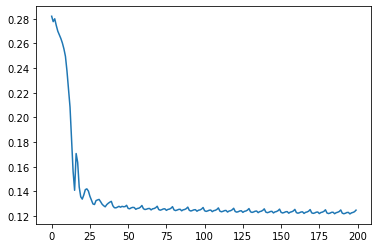

In [ ]:
plt.plot(losses)

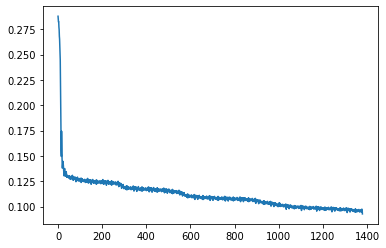

In [ ]:

plt.plot(losses)

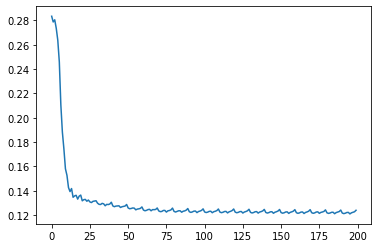

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)